# Setup

In [6]:
!pip install --upgrade yfinance
!pip install copulas
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
import random
import matplotlib.ticker as ticker
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.65
    Uninstalling yfinance-0.2.65:
      Successfully uninstalled yfinance-0.2.65
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 3.4 MB/s eta 0:00:00


## ETF Flow Estimation

/tmp/ipython-input-621530567.py:75: RuntimeWarning: overflow encountered in accumulate
  ax2.plot(100 + 100*((1+eth_returns).cumprod()-1), color='red', label='ETH Price')
/tmp/ipython-input-621530567.py:75: RuntimeWarning: overflow encountered in multiply
  ax2.plot(100 + 100*((1+eth_returns).cumprod()-1), color='red', label='ETH Price')
/usr/local/lib/python3.12/dist-packages/matplotlib/axes/_base.py:3024: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


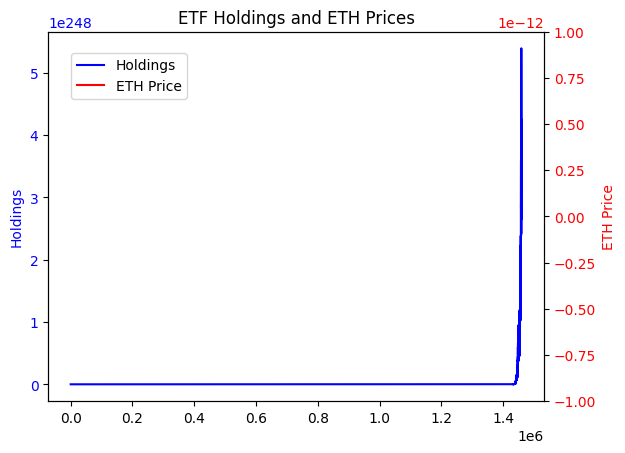

In [7]:
# Simulation Parameters:

# For replicability

np.random.seed(42)

# number of draws to simluate flow and redemptions (2000 years)
ndraws = 4000*365

# Impulse Response (in opposite direction, from oldest to newest response)
# This is how flow_change responds to lags of Asset Returns (starting from lag6 to lag1 and lag0)
# These estimate come from the Impulse Response Analysis section
impulse_response = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.05]
impulse_length = len(impulse_response)

# Define volatility of eth returns. You can run the code below to see that ETH
# volatility is about 4% daily over the last 7 years.
eth_vol = 0.04

'''
# Define Underlying Asset Volatility # ASSUMPTION ETH returns are lognormal
price = yf.download(f'ETH-USD', start="2018-01-01", end="2025-02-15")
price.index = pd.to_datetime(price.index)
price = price['Close'][f'ETH-USD']
price
price[f'ETH_Returns'] = price.to_frame().pct_change()
eth_vol = price['ETH_Returns'].std()[0]
print(eth_vol)
'''

# Define daily Noise flow Volatility. This comes from the volatility of flow changes
# for BTC and Gold ETF. See section on BTC and Gold ETF below.
red_vol = 0.01

# Create Input Variables to ETF Flow
# ASSUMPTION: Flow Noise Flow and ETH returns are lognormally distributed
# ASSUMPTION: I give a tilt of 15% per year in returns to ETH.
# ETH beta is about 2, which means an expected return of about 15%
eth_returns = np.exp(np.random.normal(loc = 0.15/252, scale = eth_vol, size = ndraws))-1
holdings_noise_flow_pct = np.exp(np.random.normal(loc = 0, scale = red_vol, size = ndraws))-1

# Start Simulation with value of 100. Since I am adding an impulse response of length
# impulse_length, I need to start the first impulse_length obs as 100.
initial_value = 100  # Starting asset value
holdings_amount = [initial_value]*impulse_length
holdings_amount_pct_change = [initial_value]*impulse_length

# This is the core of the simulation. For each date, (starting after impulse length)
# I first estimate the new flow. The new flow is made of two components: (1) the impulse response
# of the last 7 ETH lagged returns, and (2) a noise component.
# The impulse response is simply the sum of the dot product of the past 7 days
# returns, and the impulse response coefficients.
# Once we knwo the new flow (in percentage), we create the new holdings (past holding *(1+new flow and new noise flow))

for i in range(impulse_length, ndraws):
    new_flow_pct = np.sum(np.dot(eth_returns[i-impulse_length+1:i+1], impulse_response))
    new_holdings = holdings_amount[-1] * (1 + new_flow_pct + holdings_noise_flow_pct[i])
    holdings_amount.append(new_holdings)

holdings_amount_pct_change = [holdings_amount[i]/holdings_amount[i-1]  - 1 for i in range(1, len(holdings_amount))]


# Finally, I plot ETH price and ETF Holdings.

# Create a figure and axes
fig, ax1 = plt.subplots()

# Plot holdings amount on the primary y-axis (ax1)
ax1.plot(holdings_amount, color='blue', label='Holdings')
ax1.set_ylabel('Holdings', color='blue')
ax1.tick_params('y', labelcolor='blue')

# Create a secondary y-axis (ax2) for ETH returns
ax2 = ax1.twinx()
ax2.plot(100 + 100*((1+eth_returns).cumprod()-1), color='red', label='ETH Price')
ax2.set_ylabel('ETH Price', color='red')
ax2.tick_params('y', labelcolor='red')

# Add a legend
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.85))

# Set the title and x-axis label
plt.title('ETF Holdings and ETH Prices')
plt.xlabel('Time')  # Adjust if you have a specific time variable

# Display the plot
plt.show()


# Queue Modeling

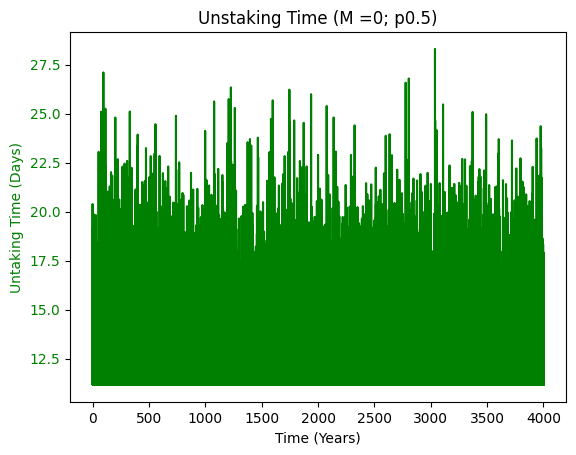

Queue Mean Time :11.640054355551177
Queue Stdev Time:1.0742067503910004


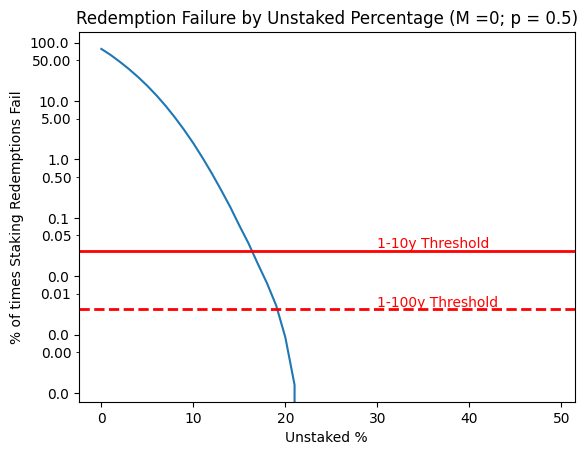

Tresh 10y:17
Tresh 100y:20


<Figure size 640x480 with 0 Axes>

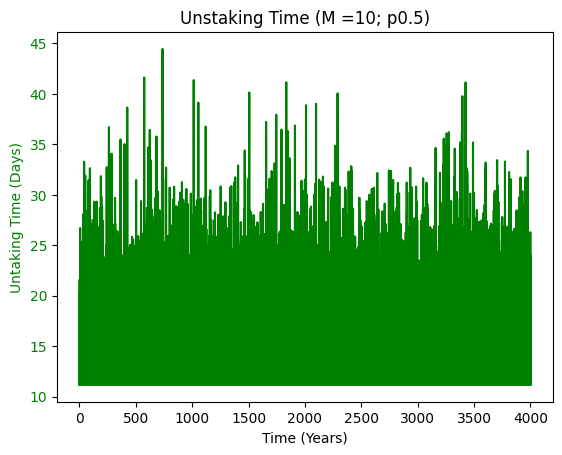

Queue Mean Time :12.009999834496405
Queue Stdev Time:2.0511201806807886


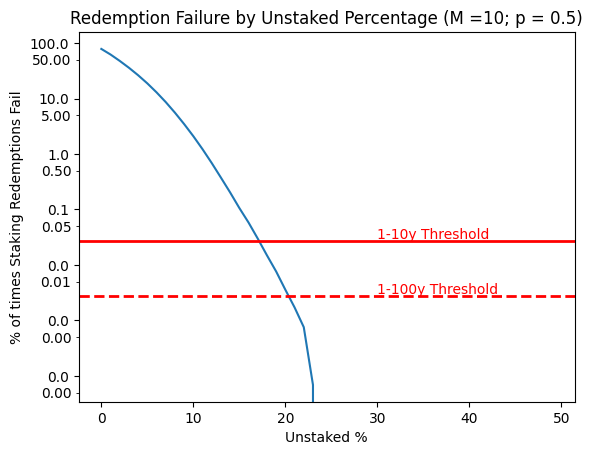

Tresh 10y:18
Tresh 100y:21


<Figure size 640x480 with 0 Axes>

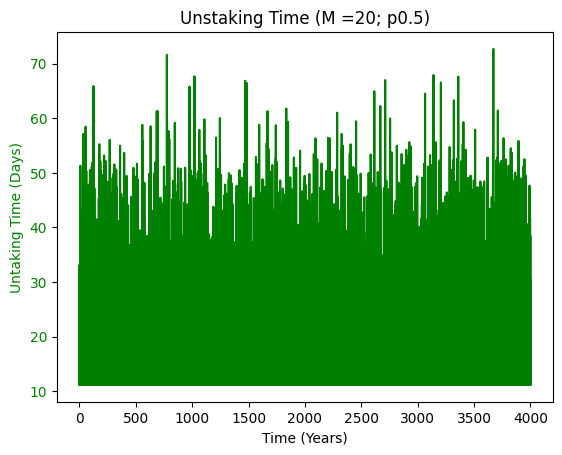

Queue Mean Time :13.130318090290945
Queue Stdev Time:4.948411705784852


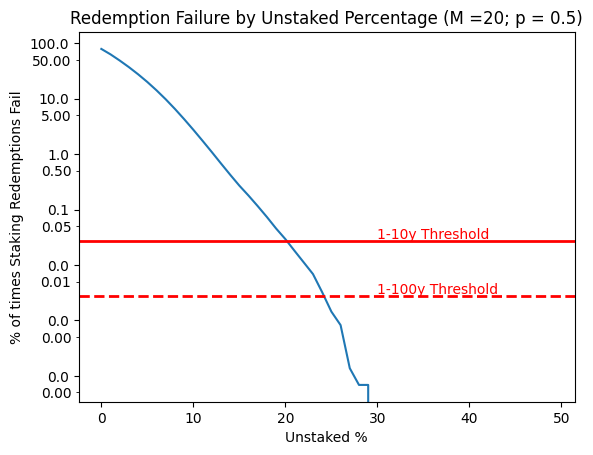

Tresh 10y:21
Tresh 100y:25


<Figure size 640x480 with 0 Axes>

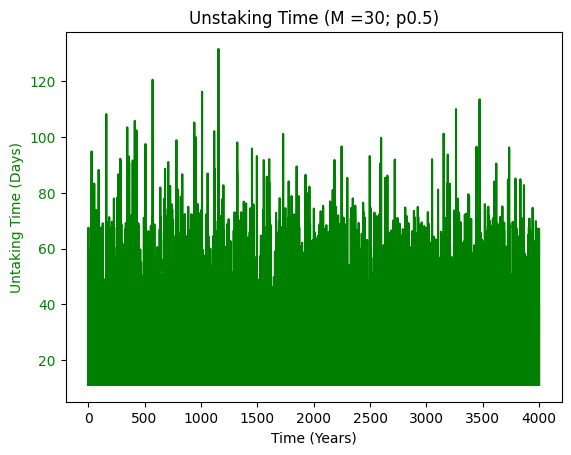

Queue Mean Time :15.030907921225534
Queue Stdev Time:9.163370438109077


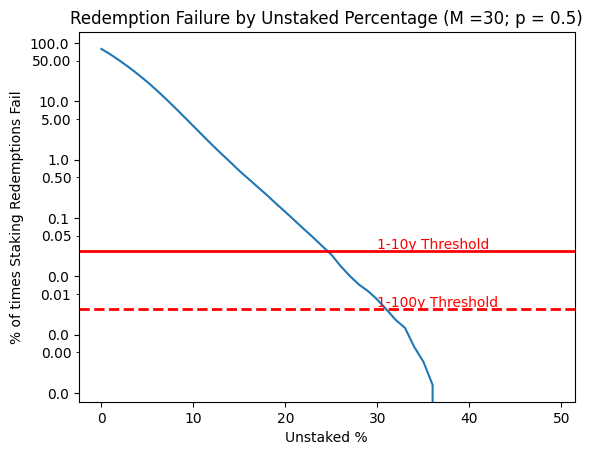

Tresh 10y:25
Tresh 100y:31


<Figure size 640x480 with 0 Axes>

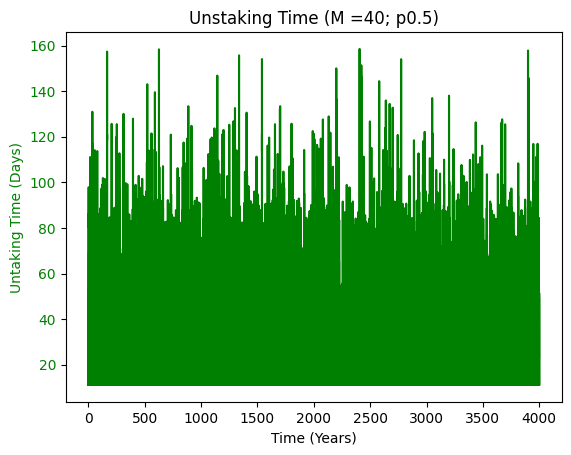

Queue Mean Time :18.067277316259133
Queue Stdev Time:14.829376841144617


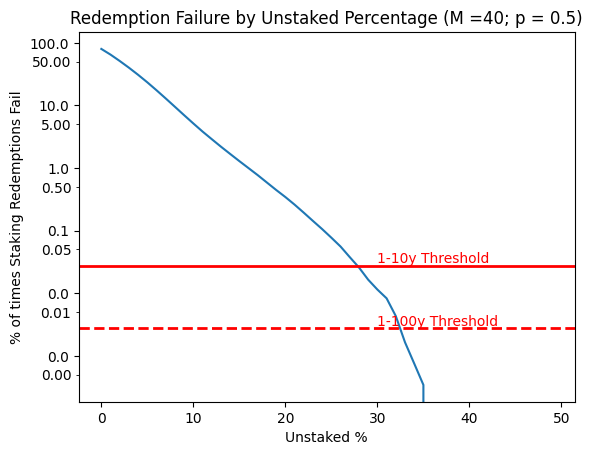

Tresh 10y:28
Tresh 100y:33


<Figure size 640x480 with 0 Axes>

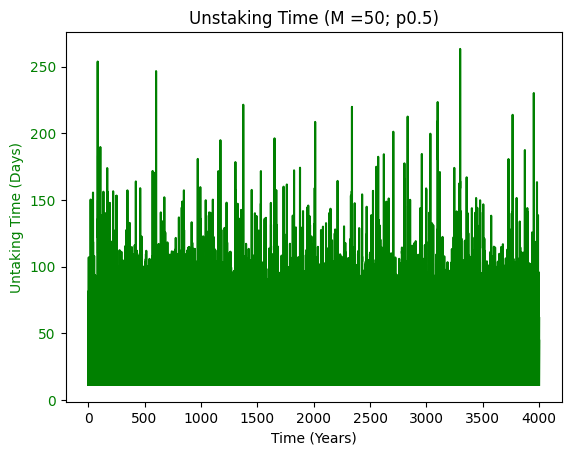

Queue Mean Time :22.30905774928029
Queue Stdev Time:21.787380949287


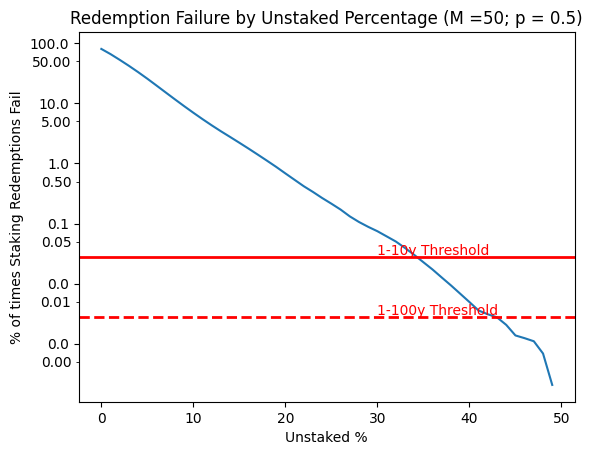

Tresh 10y:35
Tresh 100y:44


<Figure size 640x480 with 0 Axes>

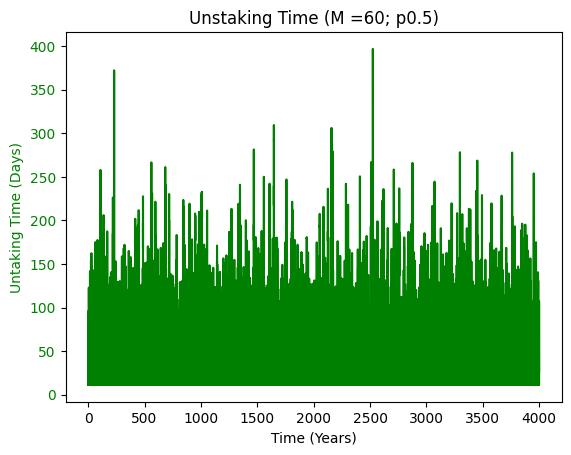

Queue Mean Time :28.55691035747352
Queue Stdev Time:31.97461693515401


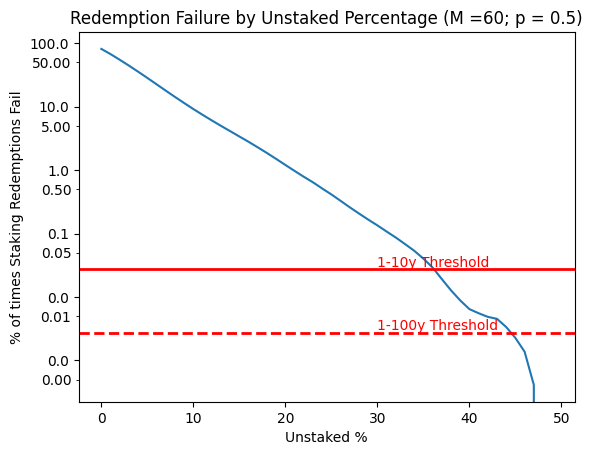

Tresh 10y:37
Tresh 100y:45


<Figure size 640x480 with 0 Axes>

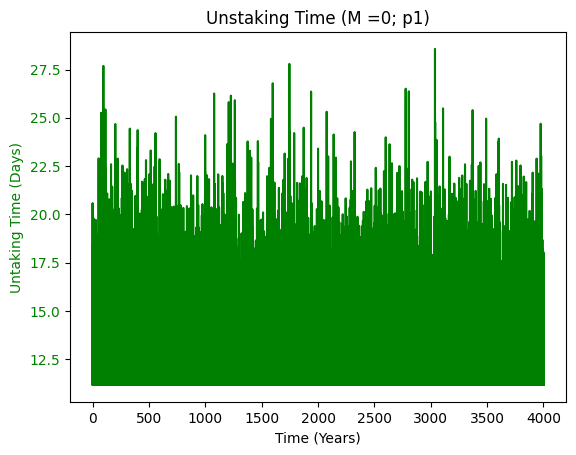

Queue Mean Time :11.640147433333025
Queue Stdev Time:1.075472093857758


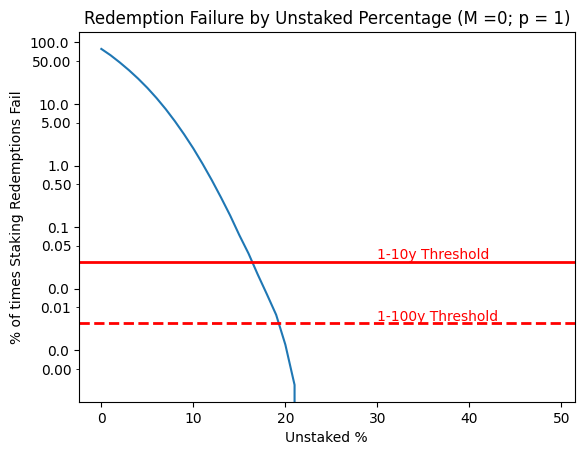

Tresh 10y:17
Tresh 100y:20


<Figure size 640x480 with 0 Axes>

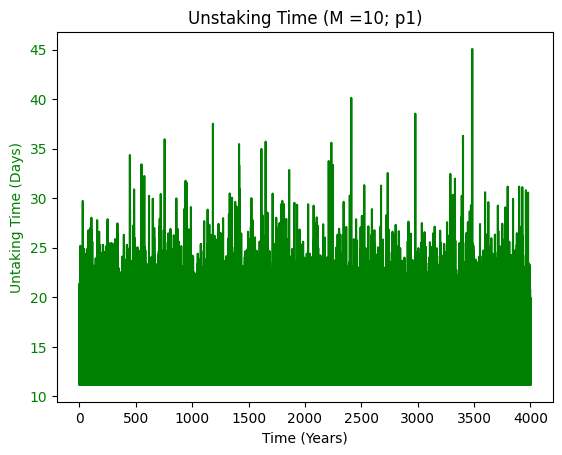

Queue Mean Time :11.820088331743381
Queue Stdev Time:1.6150545659654543


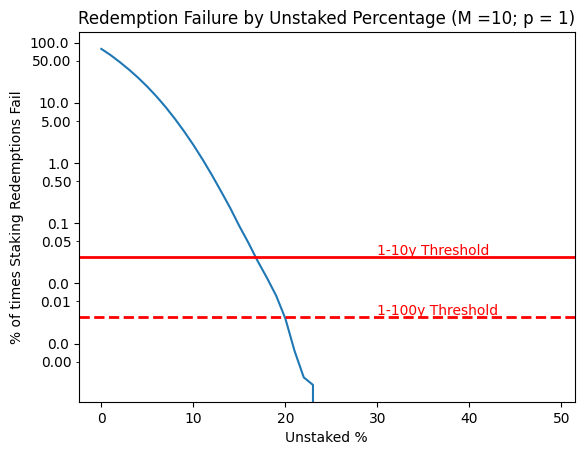

Tresh 10y:17
Tresh 100y:20


<Figure size 640x480 with 0 Axes>

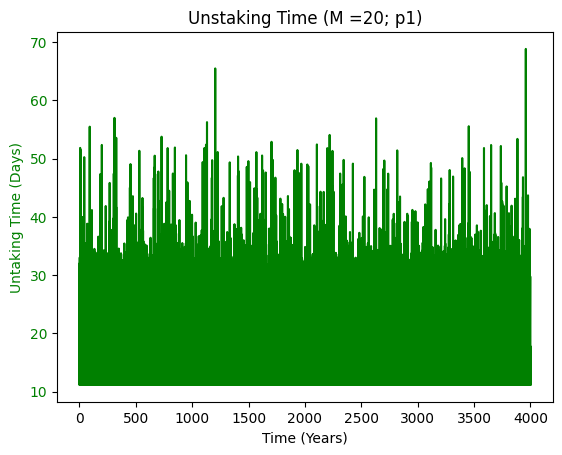

Queue Mean Time :12.354246896100117
Queue Stdev Time:3.442165195245229


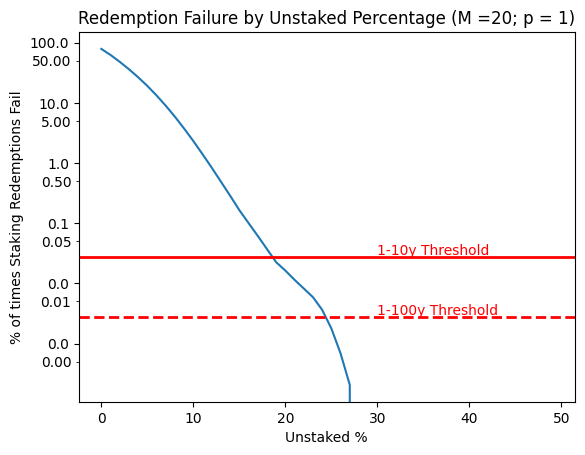

Tresh 10y:19
Tresh 100y:25


<Figure size 640x480 with 0 Axes>

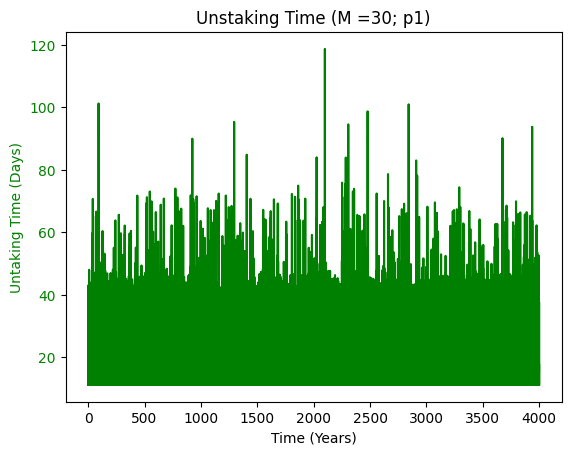

Queue Mean Time :13.186996618725443
Queue Stdev Time:6.062495886731418


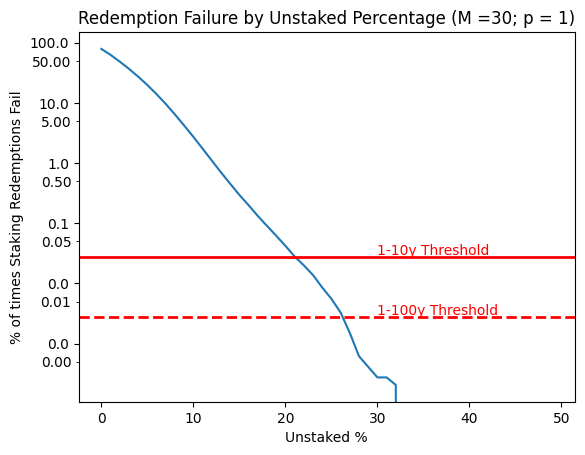

Tresh 10y:22
Tresh 100y:27


<Figure size 640x480 with 0 Axes>

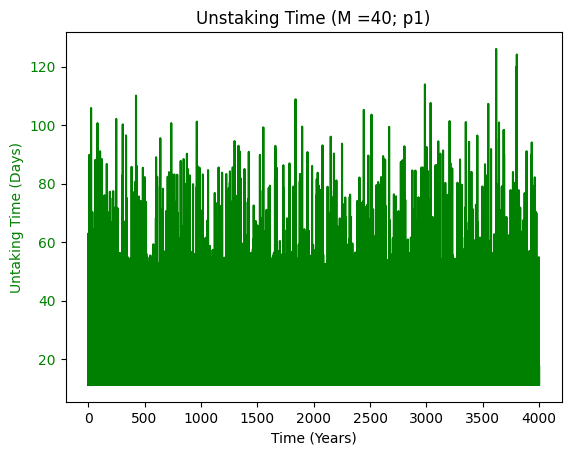

Queue Mean Time :14.522088239615124
Queue Stdev Time:9.323595364847293


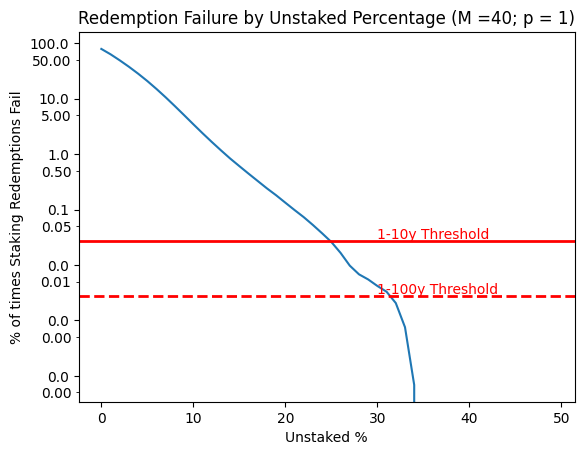

Tresh 10y:25
Tresh 100y:32


<Figure size 640x480 with 0 Axes>

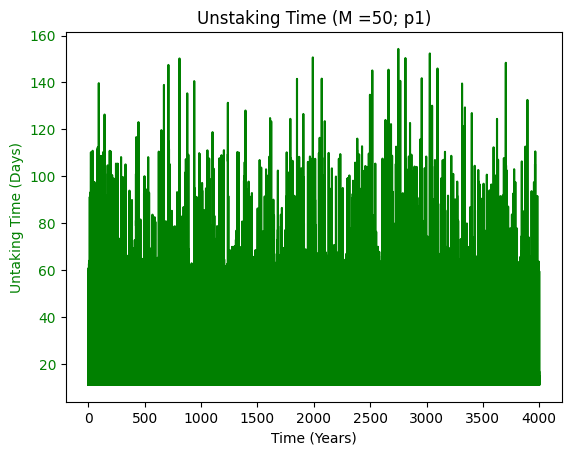

Queue Mean Time :16.21393506588368
Queue Stdev Time:13.267264617767594


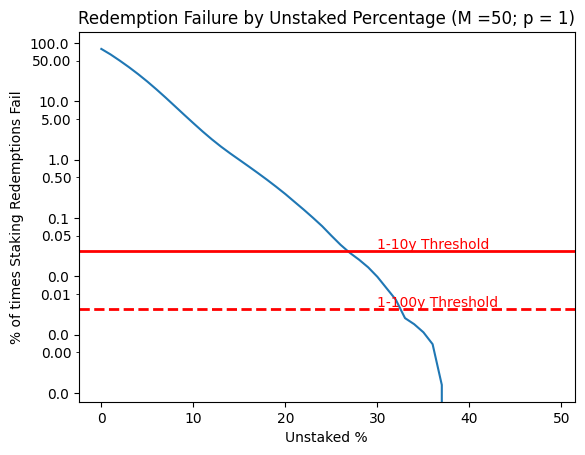

Tresh 10y:27
Tresh 100y:33


<Figure size 640x480 with 0 Axes>

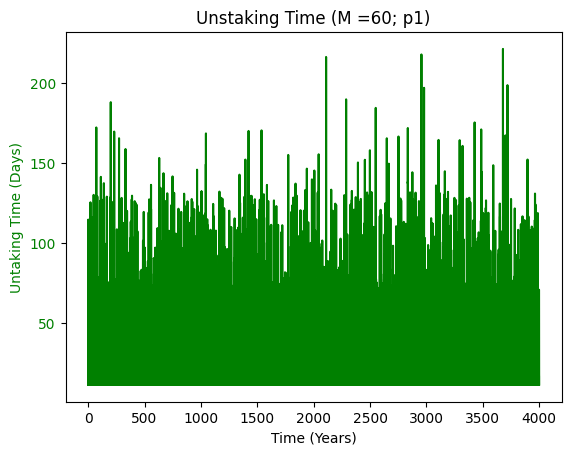

Queue Mean Time :18.31388531307527
Queue Stdev Time:17.813557846929097


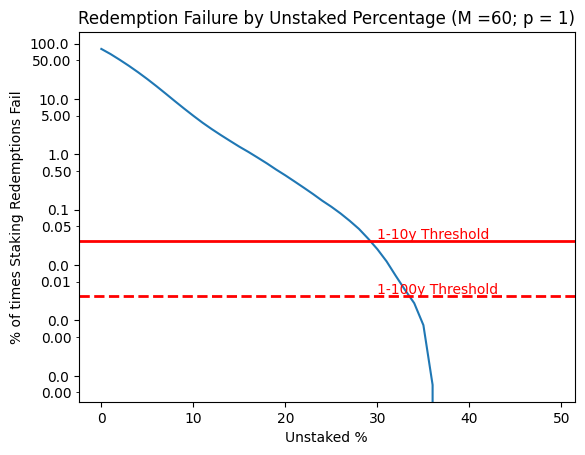

Tresh 10y:30
Tresh 100y:34


<Figure size 640x480 with 0 Axes>

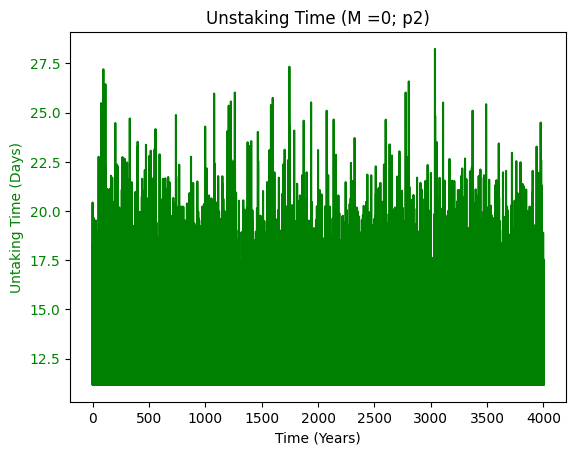

Queue Mean Time :11.639720115534708
Queue Stdev Time:1.0739631224345578


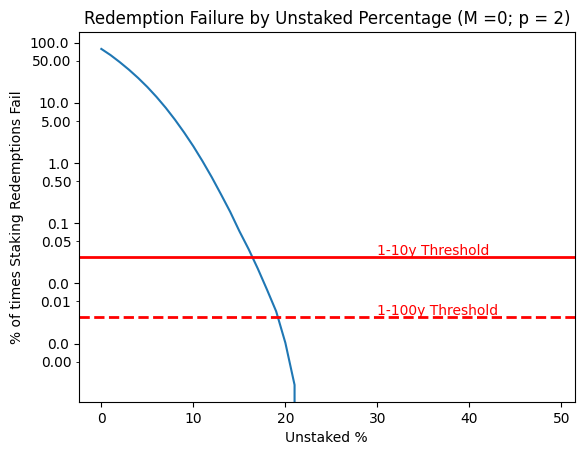

Tresh 10y:17
Tresh 100y:20


<Figure size 640x480 with 0 Axes>

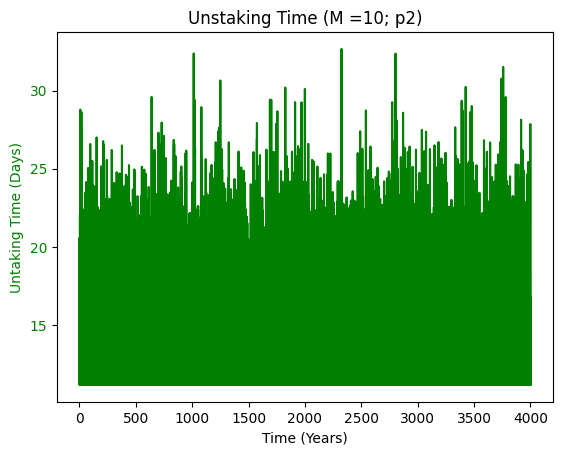

Queue Mean Time :11.732813148601805
Queue Stdev Time:1.3714185705880368


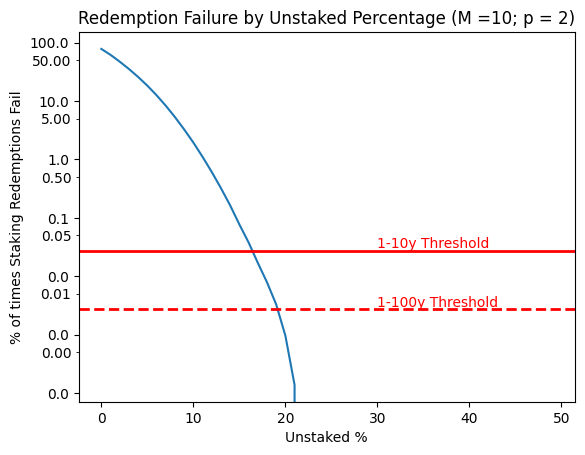

Tresh 10y:17
Tresh 100y:20


<Figure size 640x480 with 0 Axes>

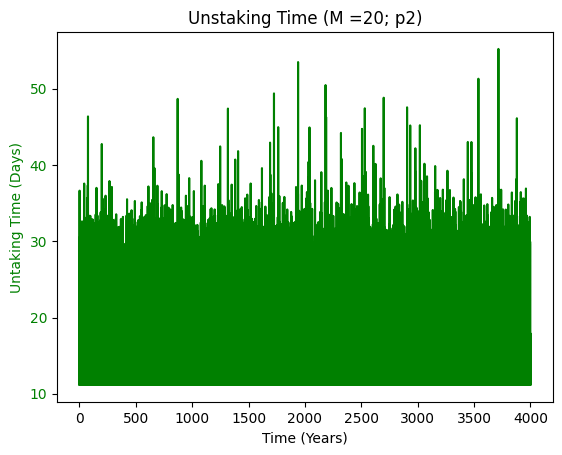

Queue Mean Time :11.962168067622905
Queue Stdev Time:2.4109492282397174


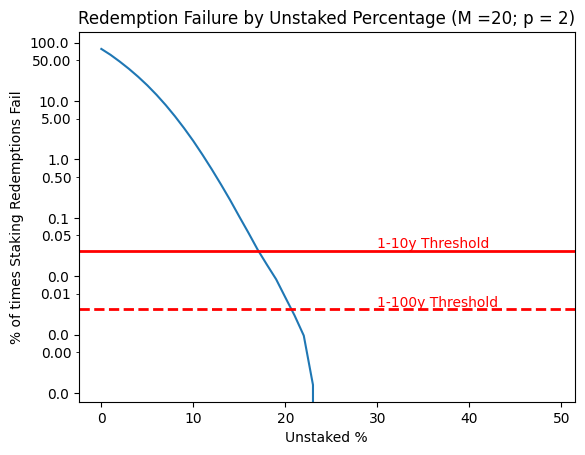

Tresh 10y:18
Tresh 100y:21


<Figure size 640x480 with 0 Axes>

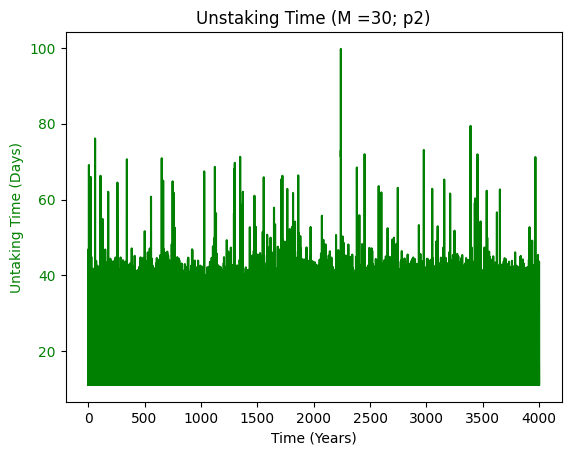

Queue Mean Time :12.369949601260126
Queue Stdev Time:4.131993300158475


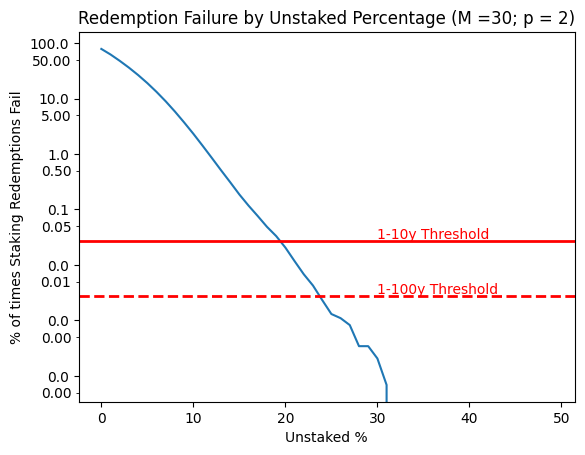

Tresh 10y:20
Tresh 100y:24


<Figure size 640x480 with 0 Axes>

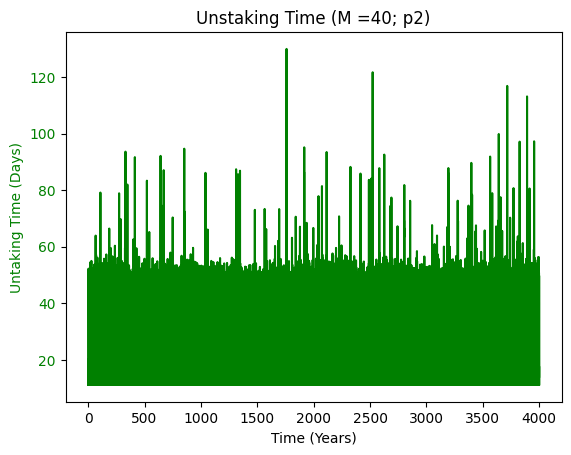

Queue Mean Time :13.008066253508307
Queue Stdev Time:6.4104186474310705


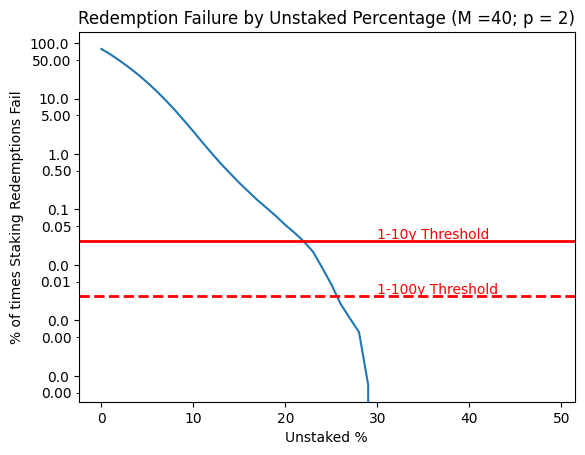

Tresh 10y:22
Tresh 100y:26


<Figure size 640x480 with 0 Axes>

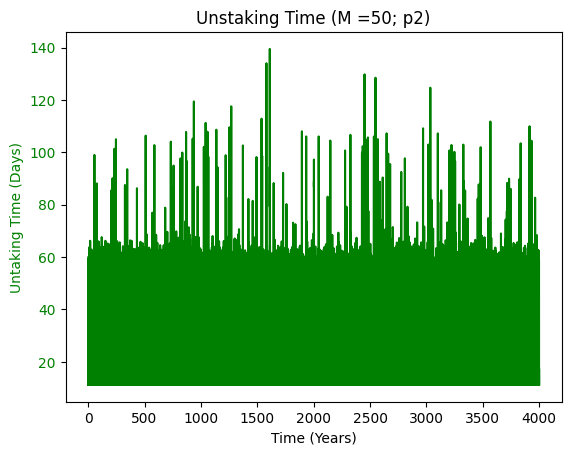

Queue Mean Time :13.712794381881272
Queue Stdev Time:8.749310235474711


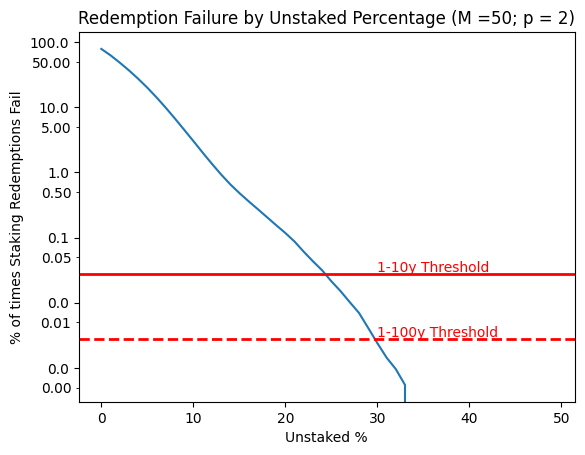

Tresh 10y:25
Tresh 100y:30


<Figure size 640x480 with 0 Axes>

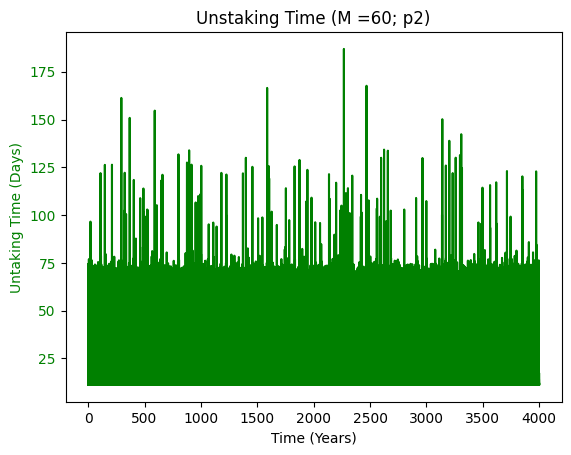

Queue Mean Time :14.649562111561487
Queue Stdev Time:11.498012363642895


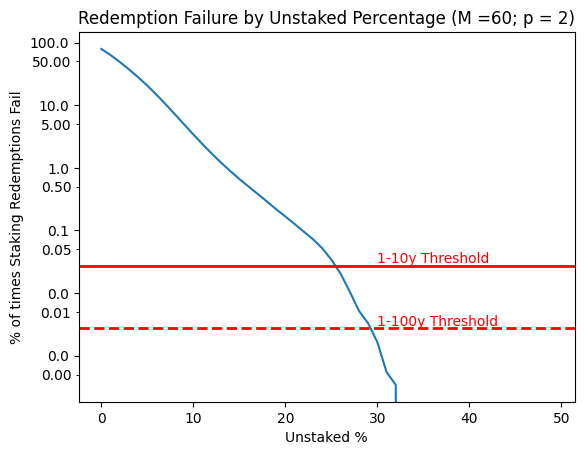

Tresh 10y:26
Tresh 100y:30


<Figure size 640x480 with 0 Axes>

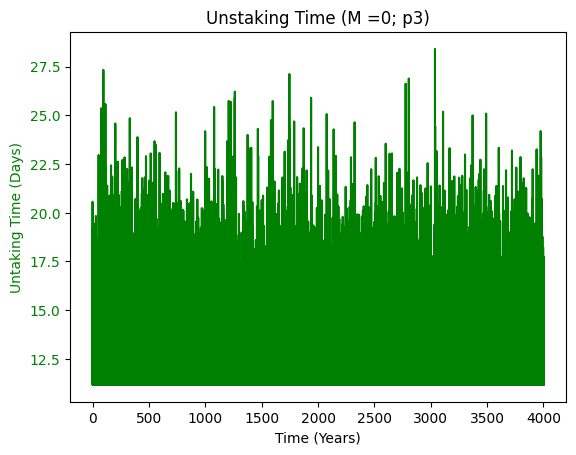

Queue Mean Time :11.64044011551462
Queue Stdev Time:1.0757057869470121


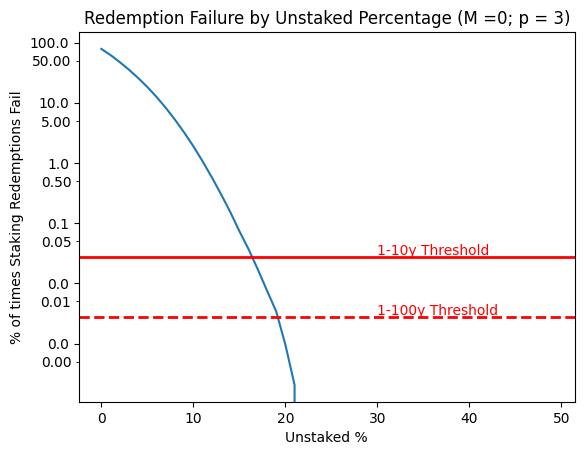

Tresh 10y:17
Tresh 100y:20


<Figure size 640x480 with 0 Axes>

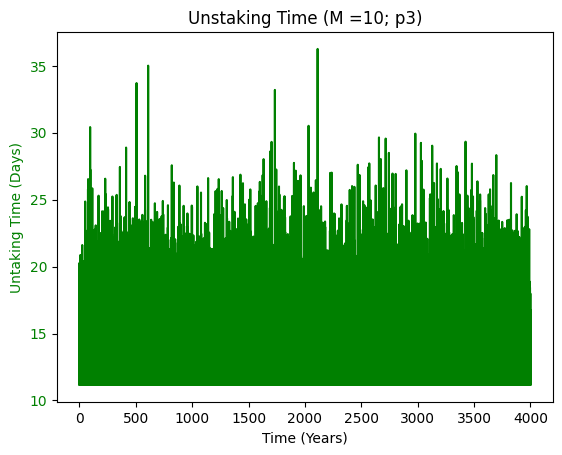

Queue Mean Time :11.70123348149916
Queue Stdev Time:1.2840809876729122


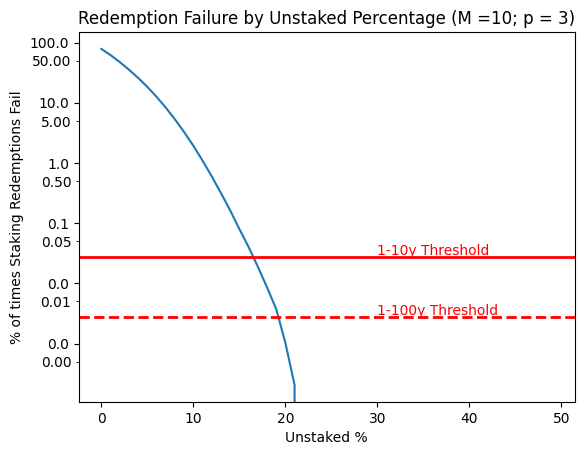

Tresh 10y:17
Tresh 100y:20


<Figure size 640x480 with 0 Axes>

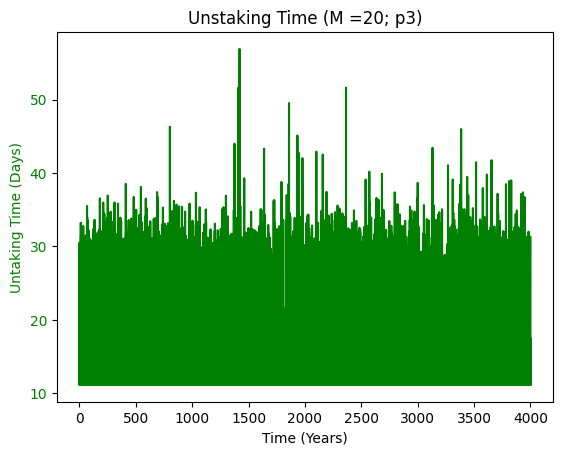

Queue Mean Time :11.847123038275305
Queue Stdev Time:2.041550643032425


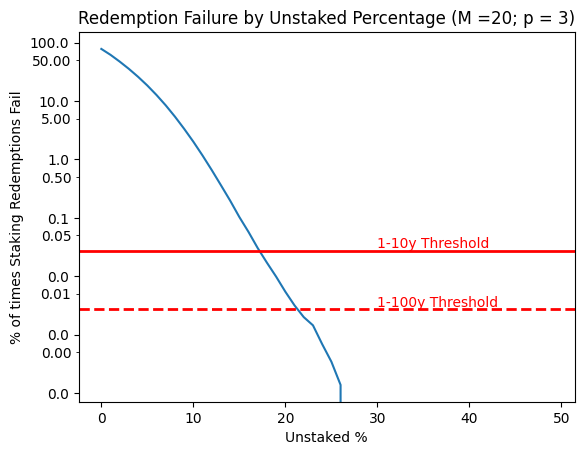

Tresh 10y:18
Tresh 100y:22


<Figure size 640x480 with 0 Axes>

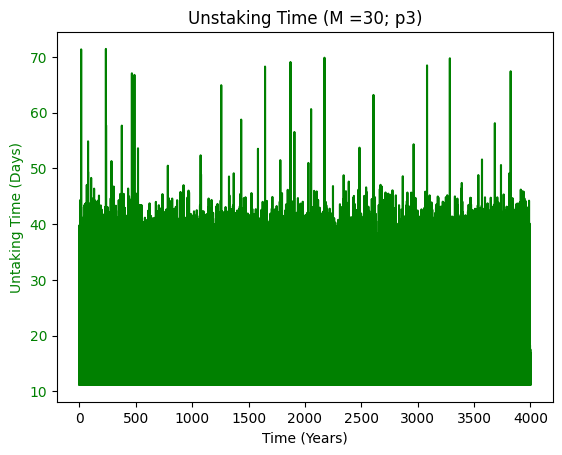

Queue Mean Time :12.129737726665645
Queue Stdev Time:3.3862053575361437


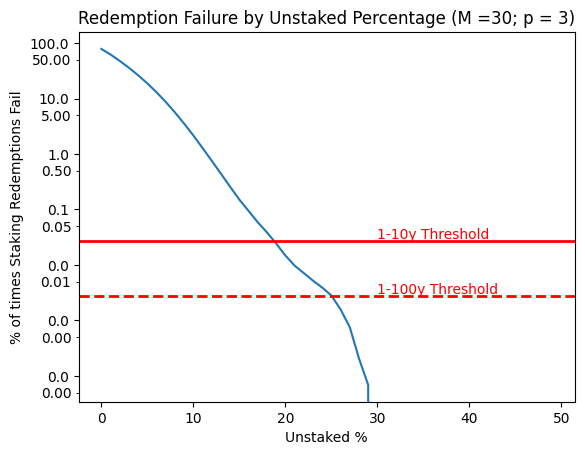

Tresh 10y:19
Tresh 100y:26


<Figure size 640x480 with 0 Axes>

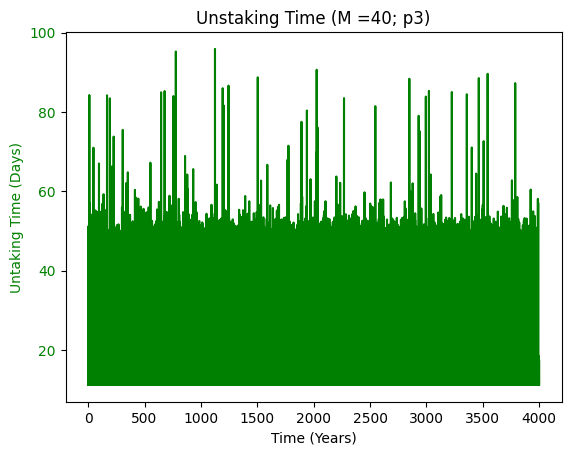

Queue Mean Time :12.507225465575846
Queue Stdev Time:5.1185077187593


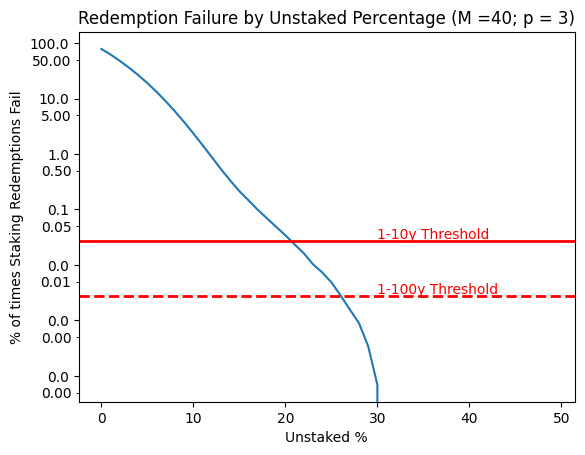

Tresh 10y:21
Tresh 100y:27


<Figure size 640x480 with 0 Axes>

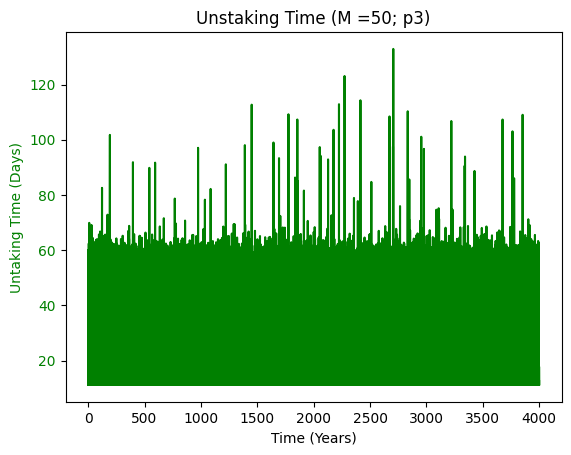

Queue Mean Time :13.029912783233907
Queue Stdev Time:7.102881341166747


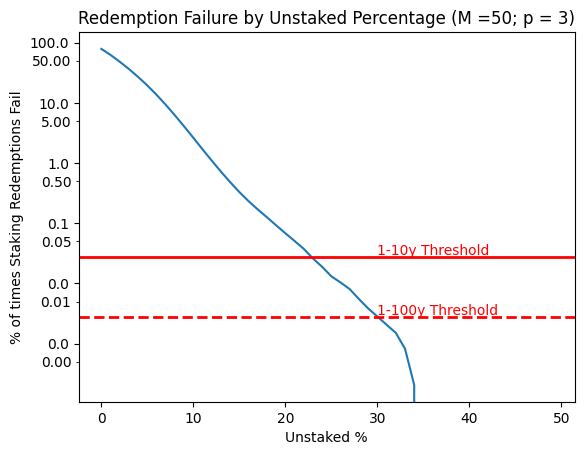

Tresh 10y:23
Tresh 100y:31


<Figure size 640x480 with 0 Axes>

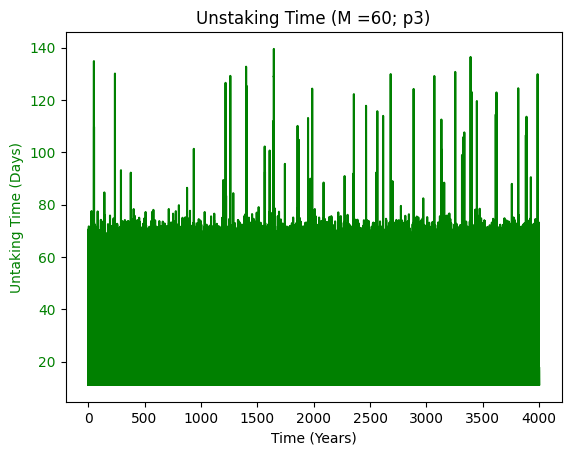

Queue Mean Time :13.584173908873206
Queue Stdev Time:9.170601326789782


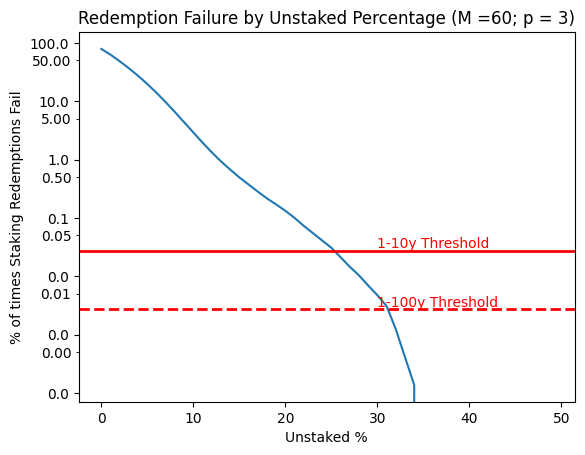

Tresh 10y:26
Tresh 100y:32


<Figure size 640x480 with 0 Axes>

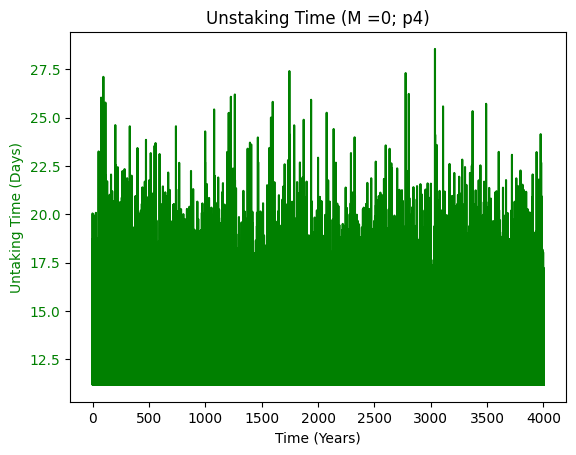

Queue Mean Time :11.639745618512848
Queue Stdev Time:1.0741481956028158


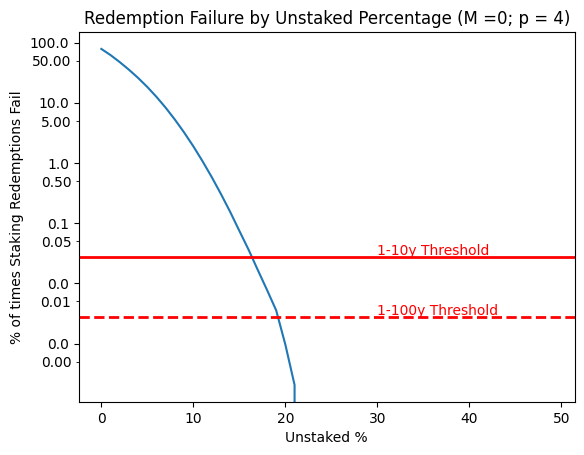

Tresh 10y:17
Tresh 100y:20


<Figure size 640x480 with 0 Axes>

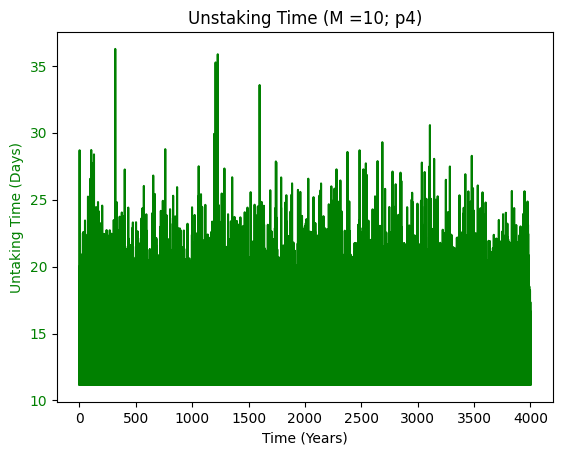

Queue Mean Time :11.6850549303667
Queue Stdev Time:1.2323454783548855


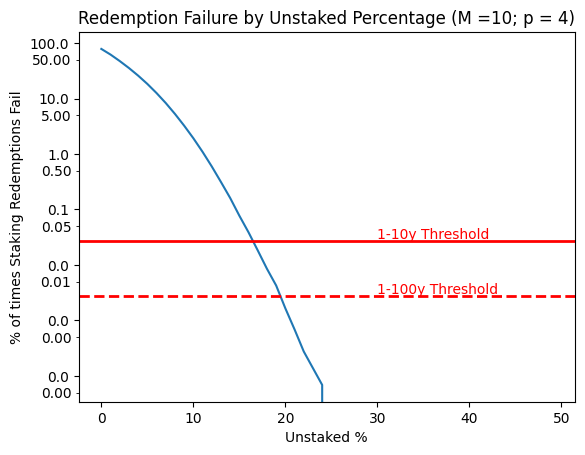

Tresh 10y:17
Tresh 100y:20


<Figure size 640x480 with 0 Axes>

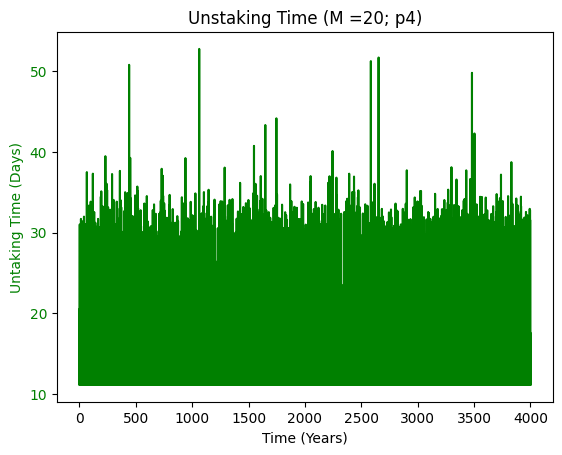

Queue Mean Time :11.804127365143081
Queue Stdev Time:1.8761866614203193


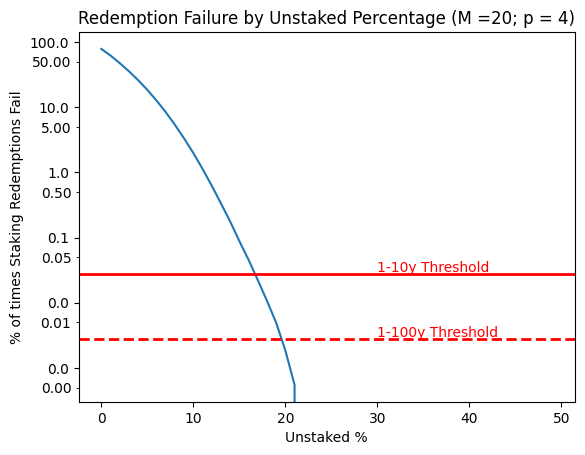

Tresh 10y:17
Tresh 100y:20


<Figure size 640x480 with 0 Axes>

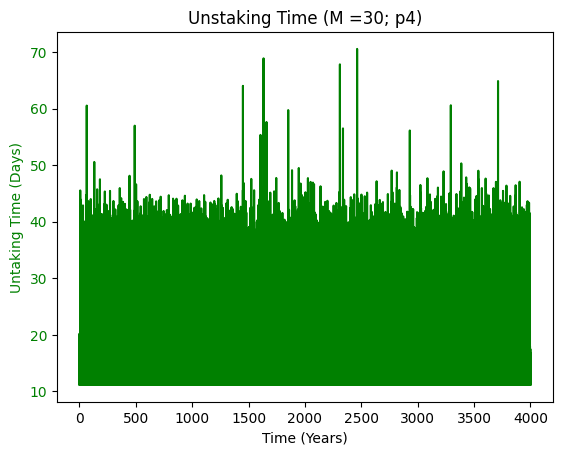

Queue Mean Time :11.993979872600294
Queue Stdev Time:2.9422939284433705


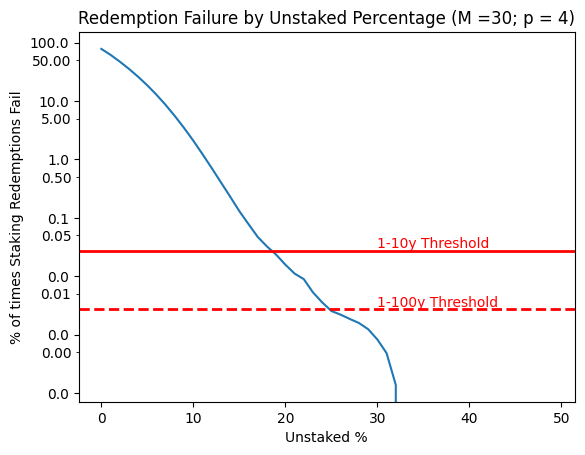

Tresh 10y:19
Tresh 100y:25


<Figure size 640x480 with 0 Axes>

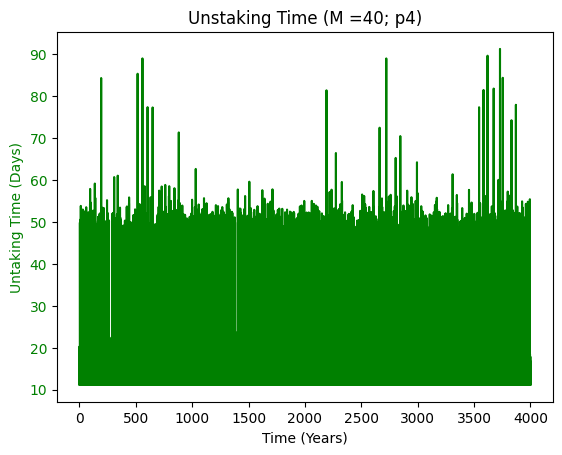

Queue Mean Time :12.251898523763568
Queue Stdev Time:4.3052018588841054


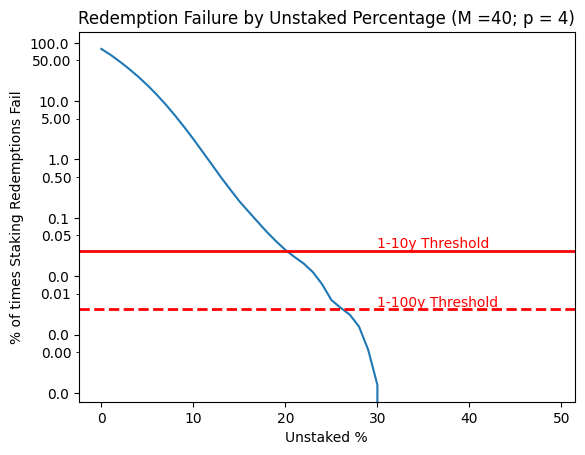

Tresh 10y:21
Tresh 100y:27


<Figure size 640x480 with 0 Axes>

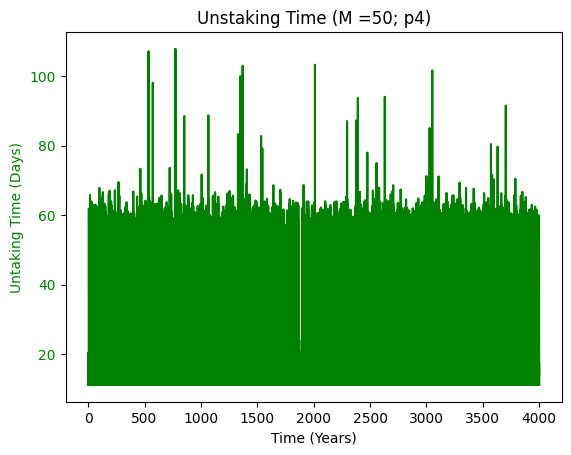

Queue Mean Time :12.62244662902668
Queue Stdev Time:5.950116110667306


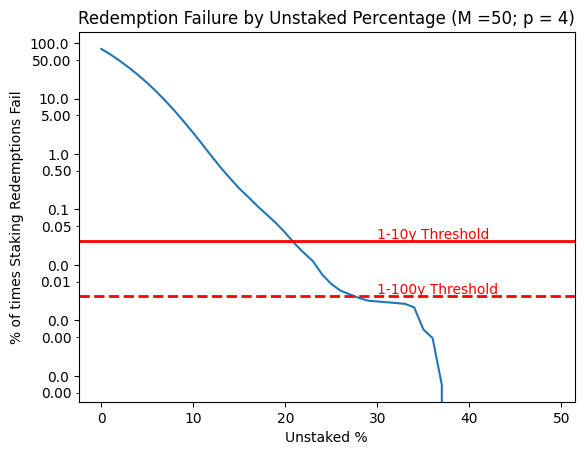

Tresh 10y:21
Tresh 100y:28


<Figure size 640x480 with 0 Axes>

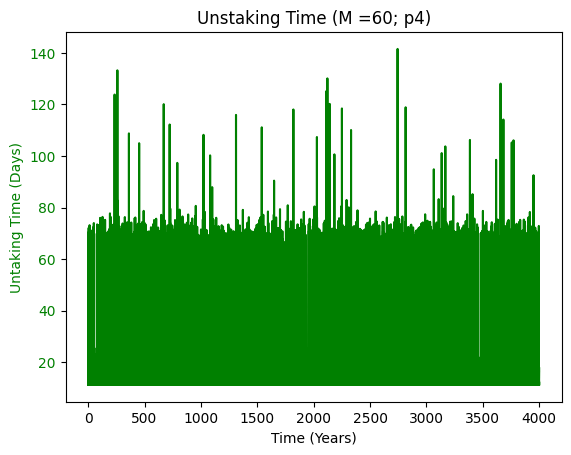

Queue Mean Time :13.07383112665109
Queue Stdev Time:7.864106580046765


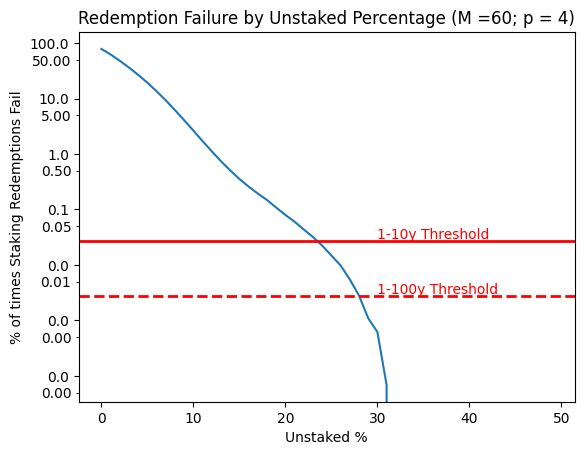

Tresh 10y:24
Tresh 100y:29


<Figure size 640x480 with 0 Axes>

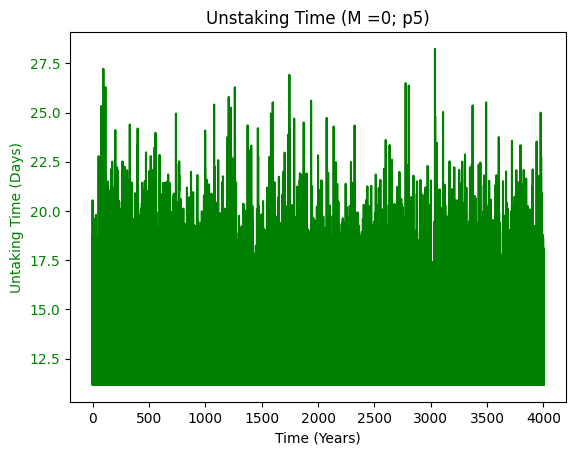

Queue Mean Time :11.639905836869215
Queue Stdev Time:1.074553321817272


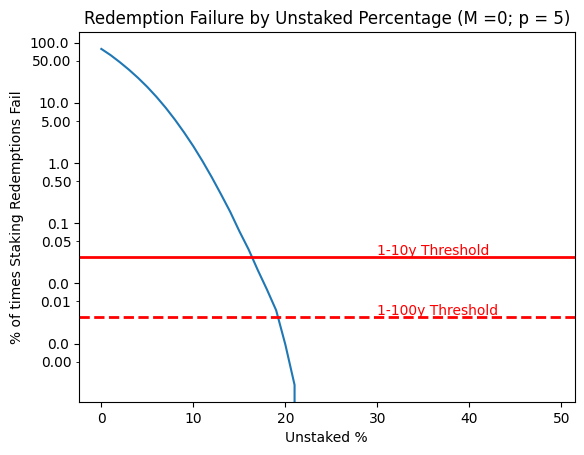

Tresh 10y:17
Tresh 100y:20


<Figure size 640x480 with 0 Axes>

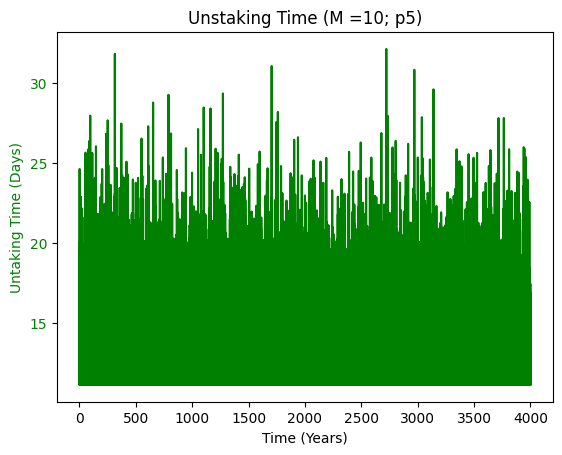

Queue Mean Time :11.676405269279106
Queue Stdev Time:1.201485468499791


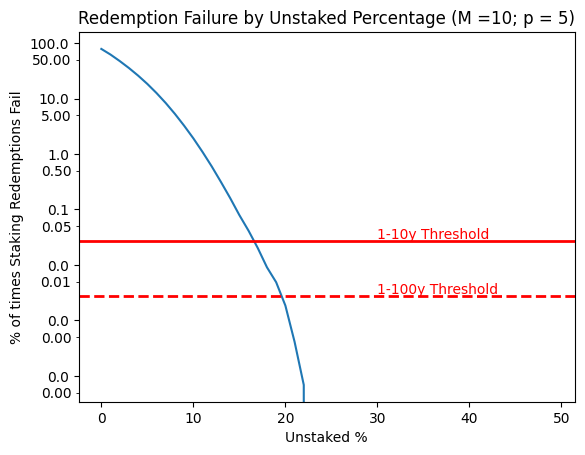

Tresh 10y:17
Tresh 100y:20


<Figure size 640x480 with 0 Axes>

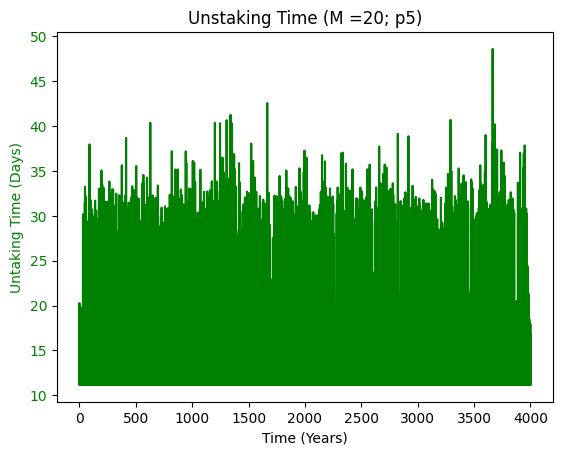

Queue Mean Time :11.765312295105772
Queue Stdev Time:1.717810185222072


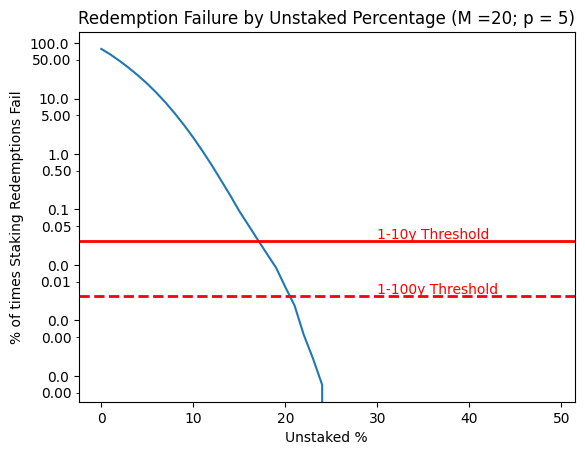

Tresh 10y:18
Tresh 100y:21


<Figure size 640x480 with 0 Axes>

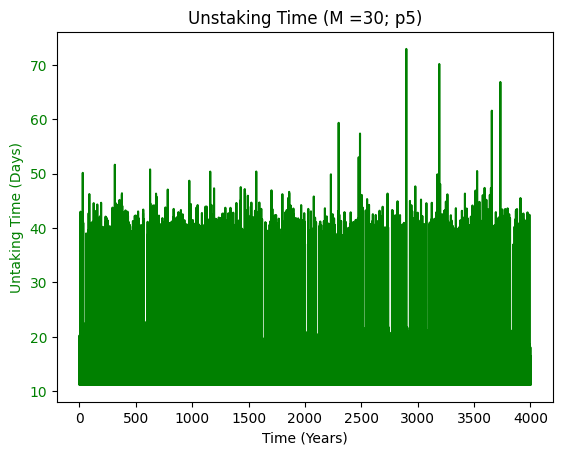

Queue Mean Time :11.904909562416725
Queue Stdev Time:2.6008712454347753


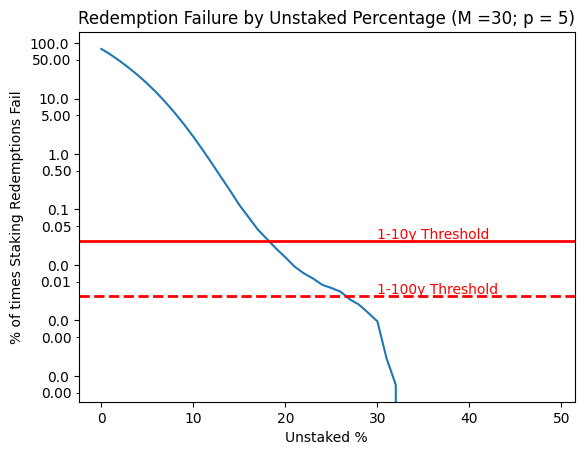

Tresh 10y:19
Tresh 100y:27


<Figure size 640x480 with 0 Axes>

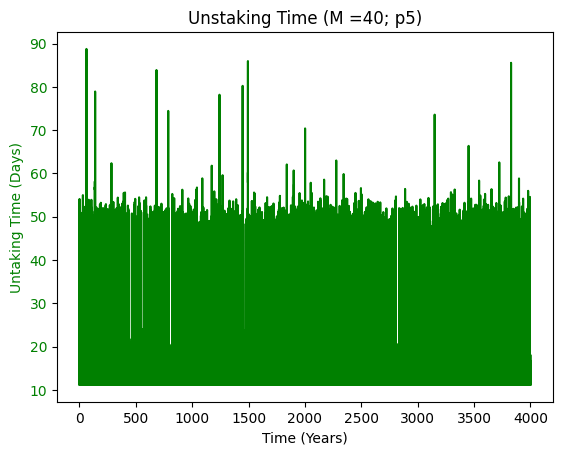

Queue Mean Time :12.150301871057874
Queue Stdev Time:3.898882997324786


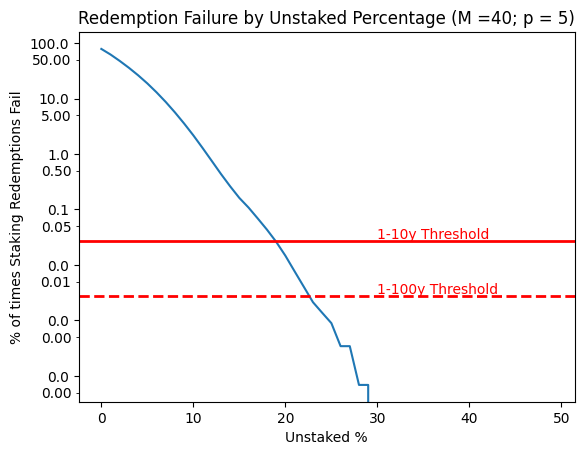

Tresh 10y:19
Tresh 100y:23


<Figure size 640x480 with 0 Axes>

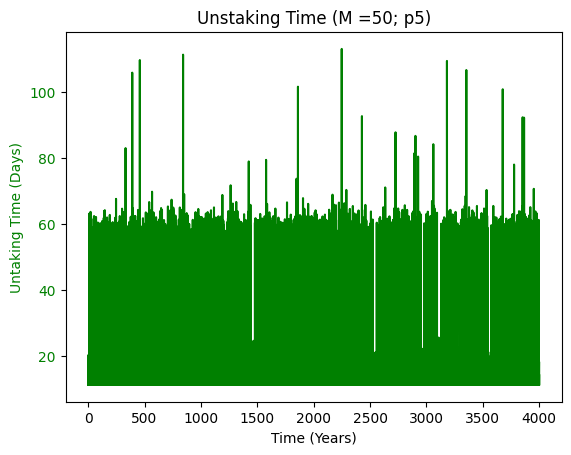

Queue Mean Time :12.442197977180555
Queue Stdev Time:5.417993684081349


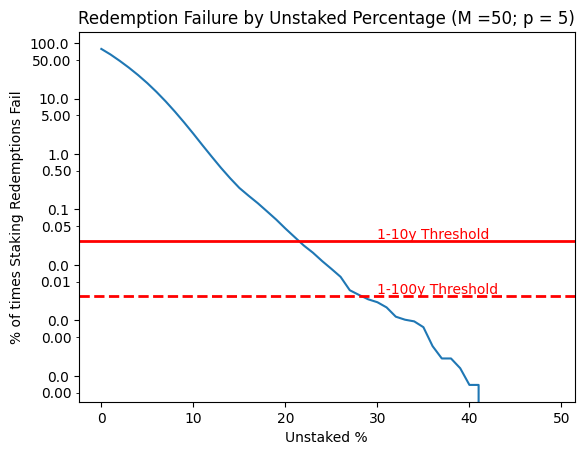

Tresh 10y:22
Tresh 100y:29


<Figure size 640x480 with 0 Axes>

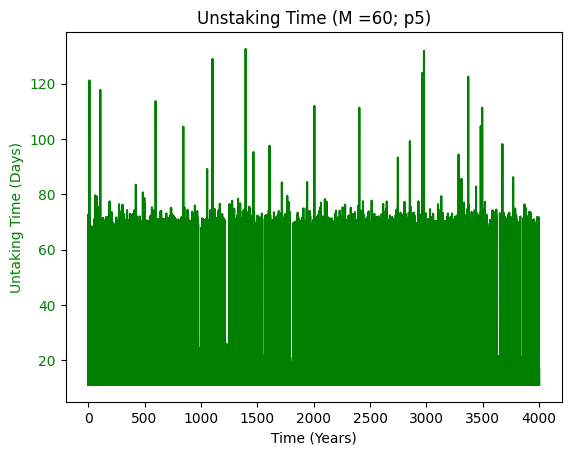

Queue Mean Time :12.80705011927688
Queue Stdev Time:7.055503103438308


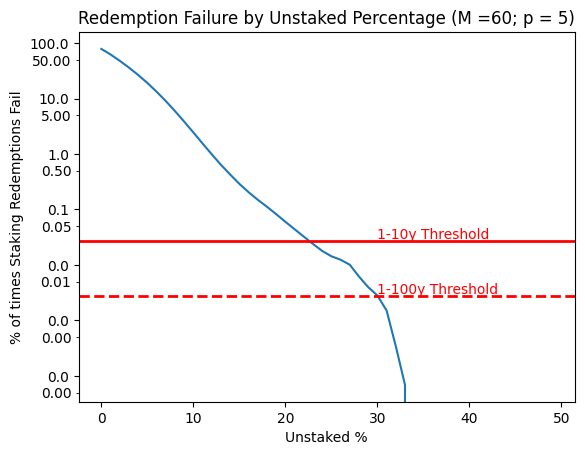

Tresh 10y:23
Tresh 100y:31


<Figure size 640x480 with 0 Axes>

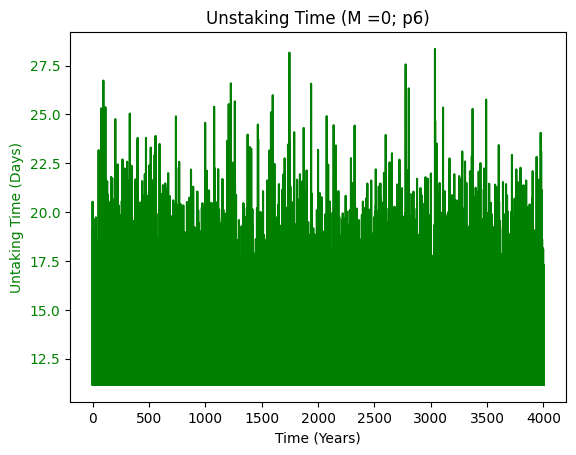

Queue Mean Time :11.64018032509515
Queue Stdev Time:1.0753001010990306


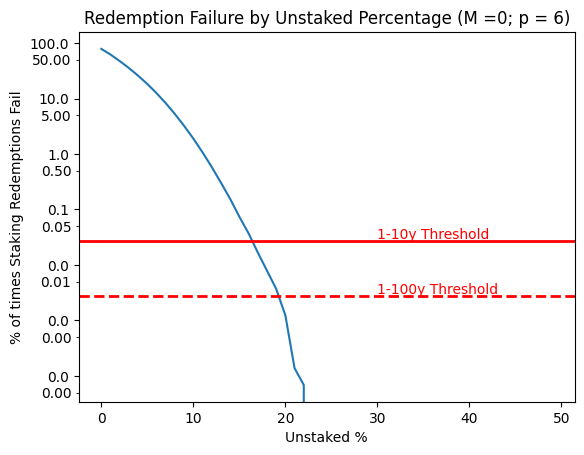

Tresh 10y:17
Tresh 100y:20


<Figure size 640x480 with 0 Axes>

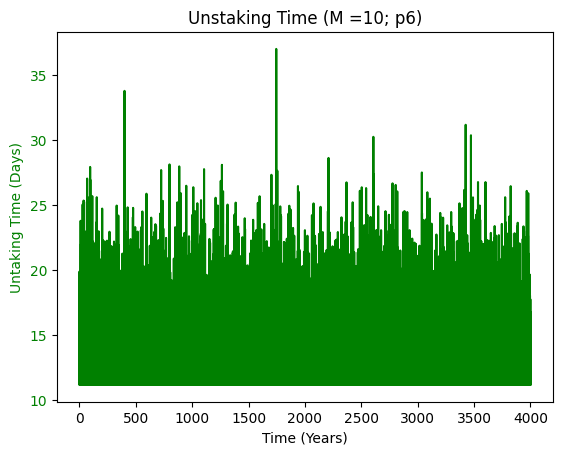

Queue Mean Time :11.672240995615793
Queue Stdev Time:1.1914660318017178


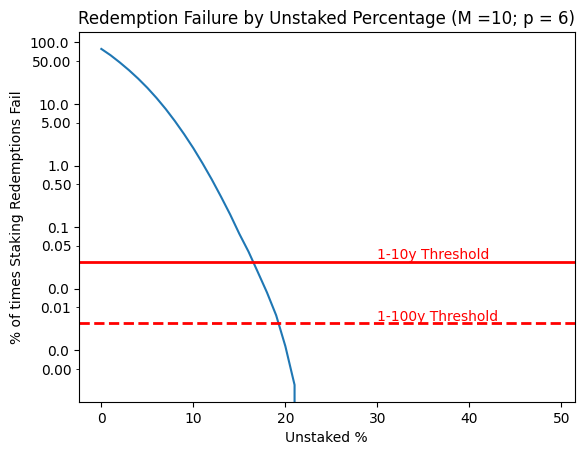

Tresh 10y:17
Tresh 100y:20


<Figure size 640x480 with 0 Axes>

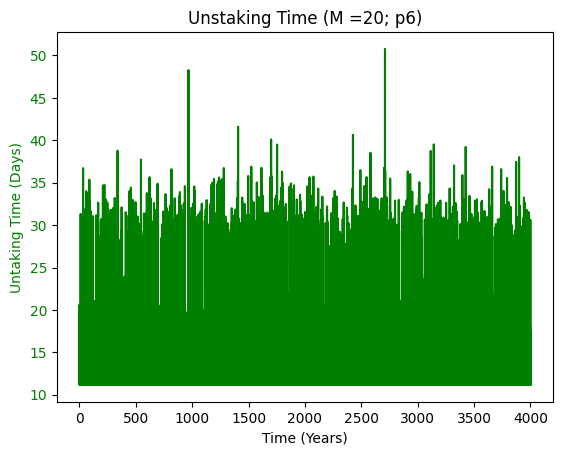

Queue Mean Time :11.749292660473172
Queue Stdev Time:1.652449230300617


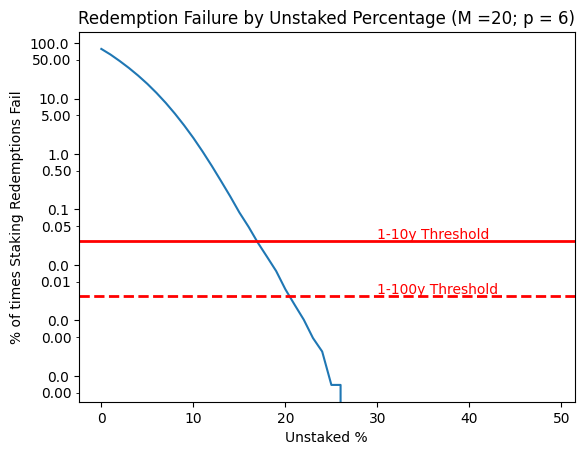

Tresh 10y:17
Tresh 100y:21


<Figure size 640x480 with 0 Axes>

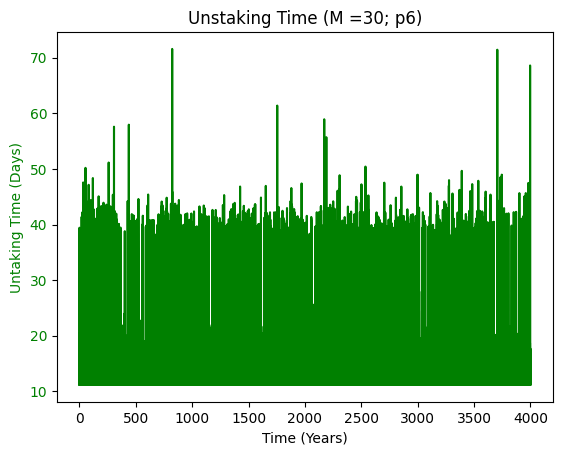

Queue Mean Time :11.881947100393855
Queue Stdev Time:2.5046249896846655


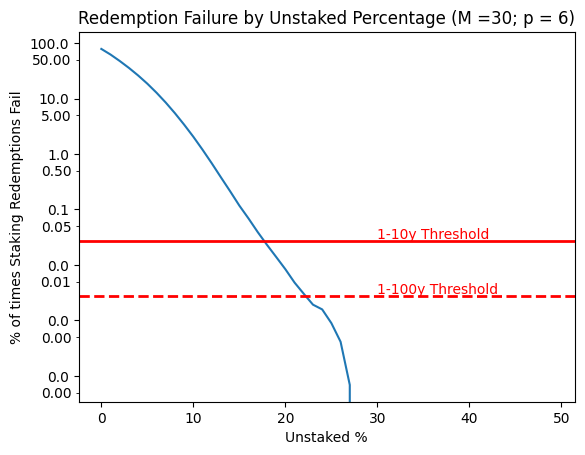

Tresh 10y:18
Tresh 100y:23


<Figure size 640x480 with 0 Axes>

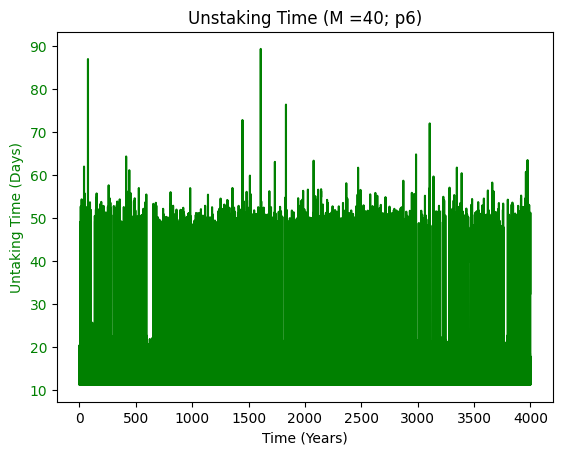

Queue Mean Time :12.08072635098967
Queue Stdev Time:3.676600787291263


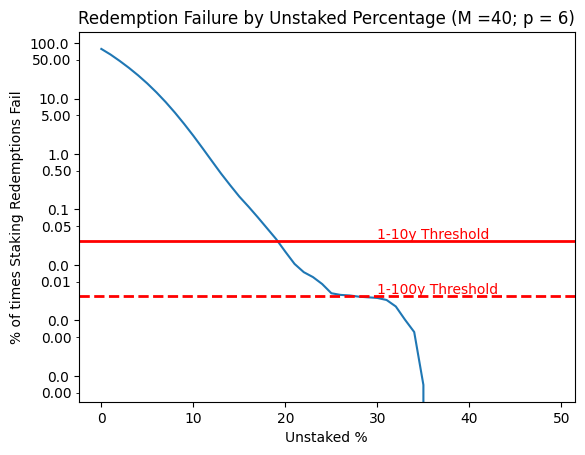

Tresh 10y:20
Tresh 100y:28


<Figure size 640x480 with 0 Axes>

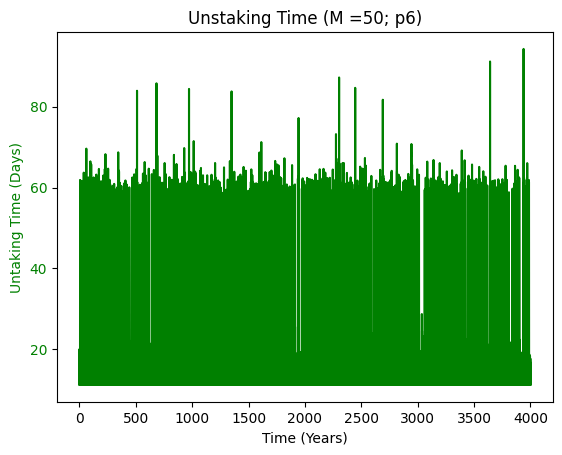

Queue Mean Time :12.28422715032023
Queue Stdev Time:4.813326045295254


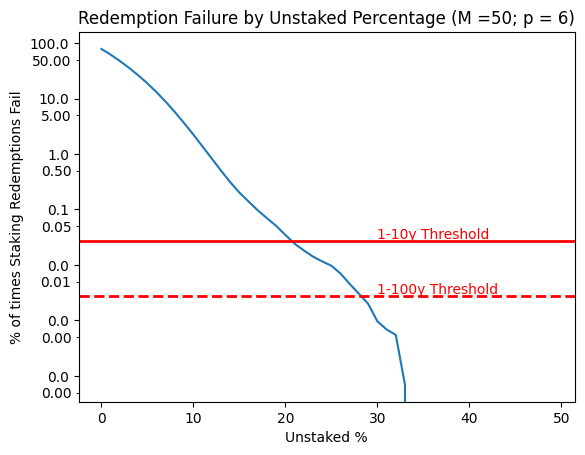

Tresh 10y:21
Tresh 100y:29


<Figure size 640x480 with 0 Axes>

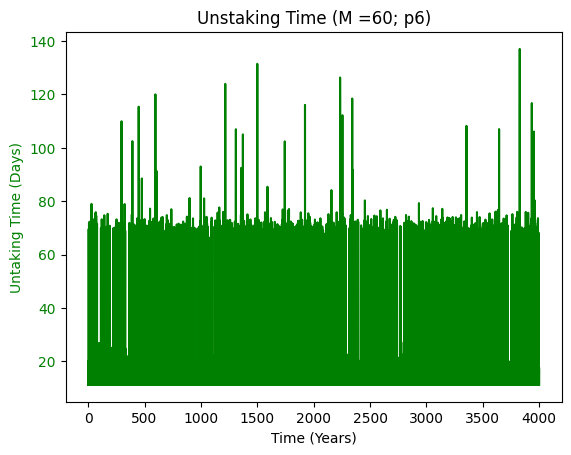

Queue Mean Time :12.612174610734717
Queue Stdev Time:6.517945989820134


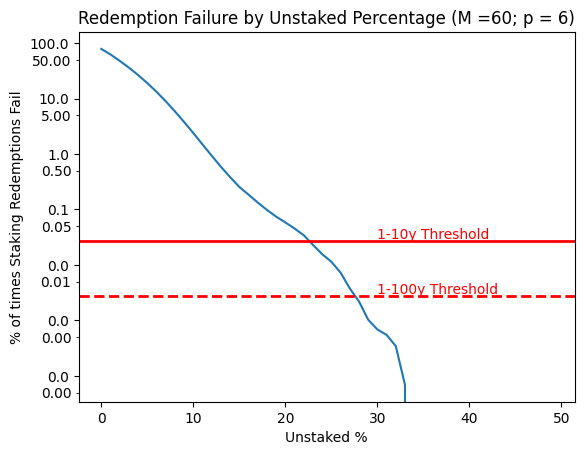

Tresh 10y:23
Tresh 100y:28


<Figure size 640x480 with 0 Axes>

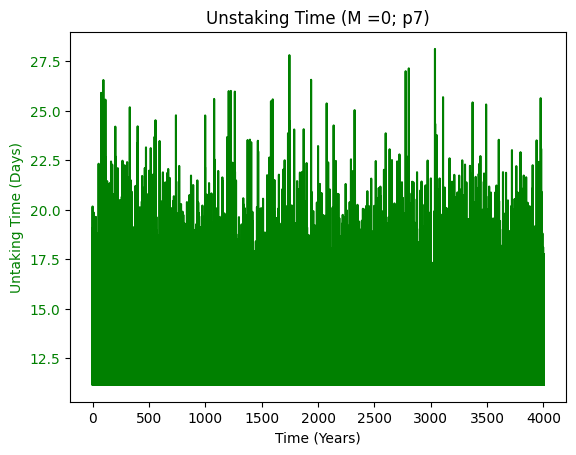

Queue Mean Time :11.64027947162265
Queue Stdev Time:1.0754743346273201


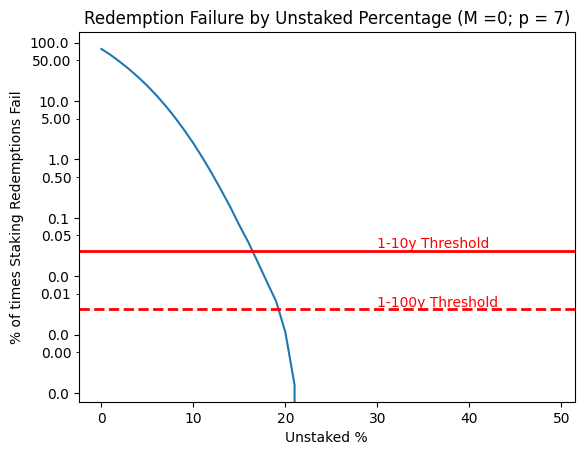

Tresh 10y:17
Tresh 100y:20


<Figure size 640x480 with 0 Axes>

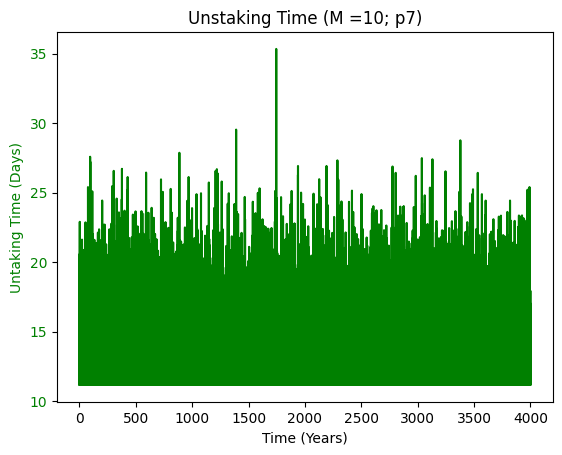

Queue Mean Time :11.665317971009756
Queue Stdev Time:1.1622949696902272


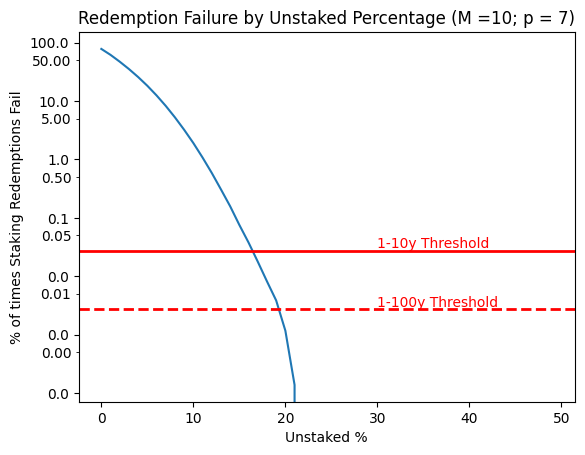

Tresh 10y:17
Tresh 100y:20


<Figure size 640x480 with 0 Axes>

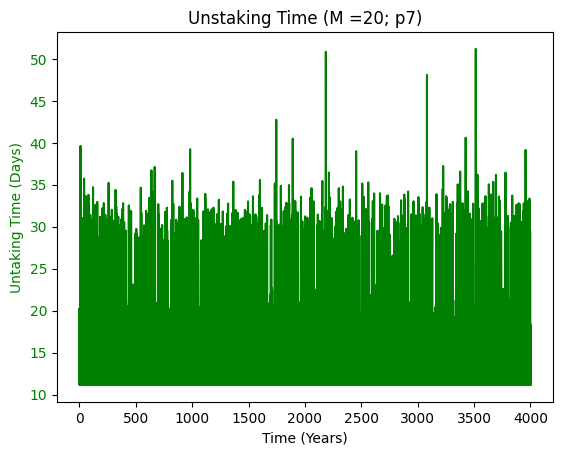

Queue Mean Time :11.731399200275433
Queue Stdev Time:1.57025078148479


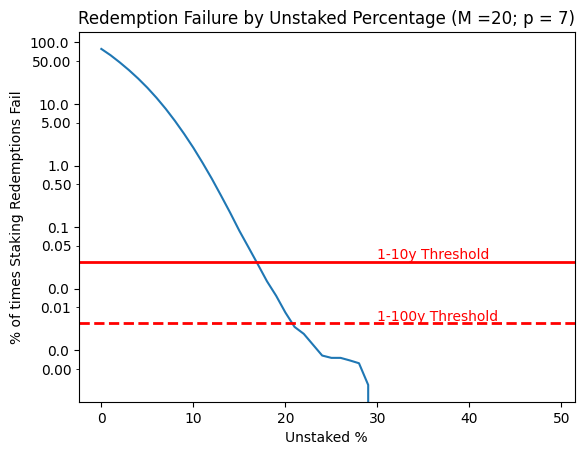

Tresh 10y:17
Tresh 100y:21


<Figure size 640x480 with 0 Axes>

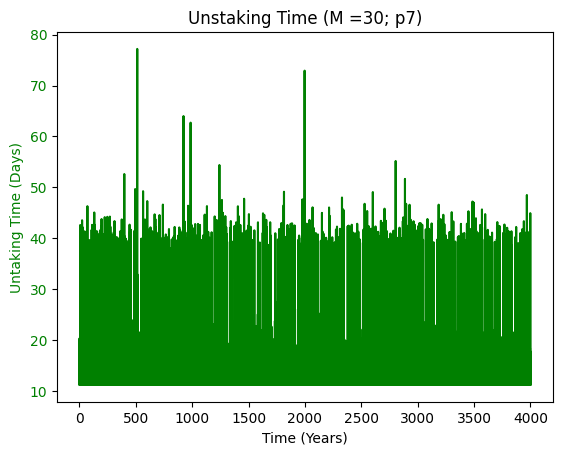

Queue Mean Time :11.846602501018625
Queue Stdev Time:2.352846882007918


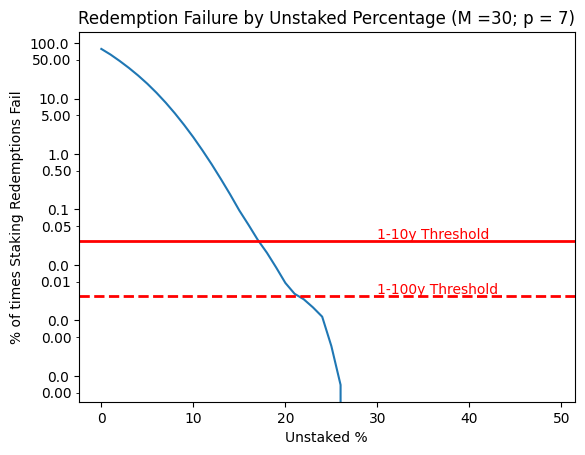

Tresh 10y:18
Tresh 100y:22


<Figure size 640x480 with 0 Axes>

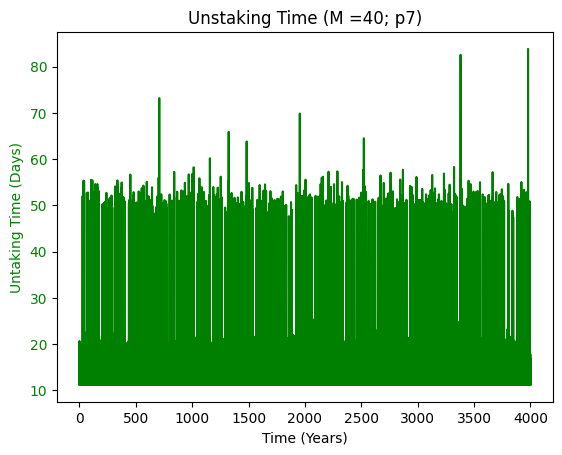

Queue Mean Time :11.983899952582503
Queue Stdev Time:3.269120432960044


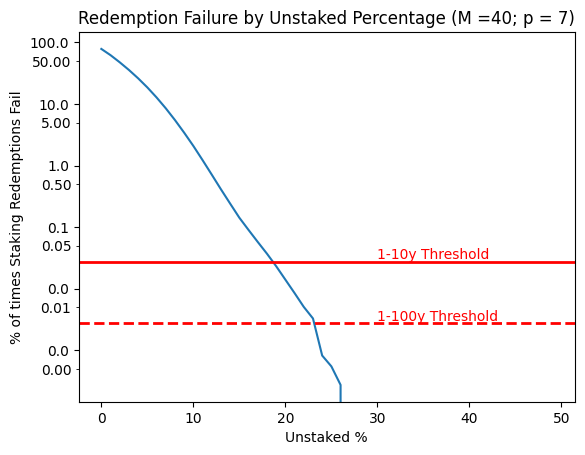

Tresh 10y:19
Tresh 100y:24


<Figure size 640x480 with 0 Axes>

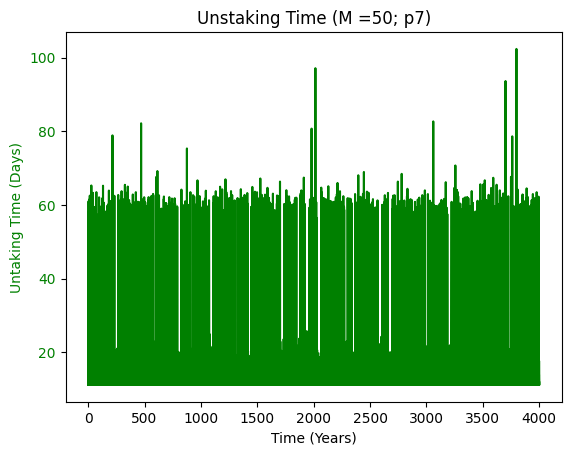

Queue Mean Time :12.156834459372693
Queue Stdev Time:4.347347360952375


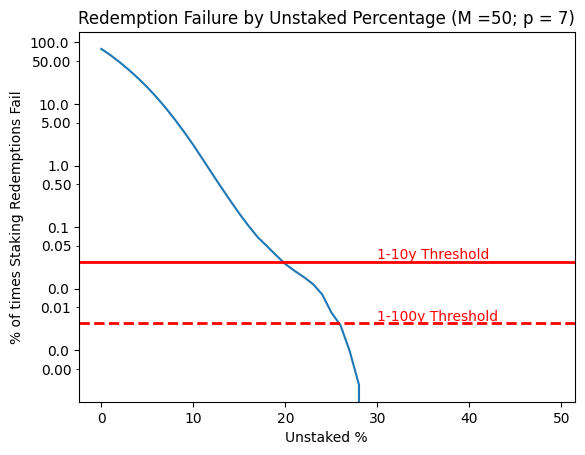

Tresh 10y:20
Tresh 100y:26


<Figure size 640x480 with 0 Axes>

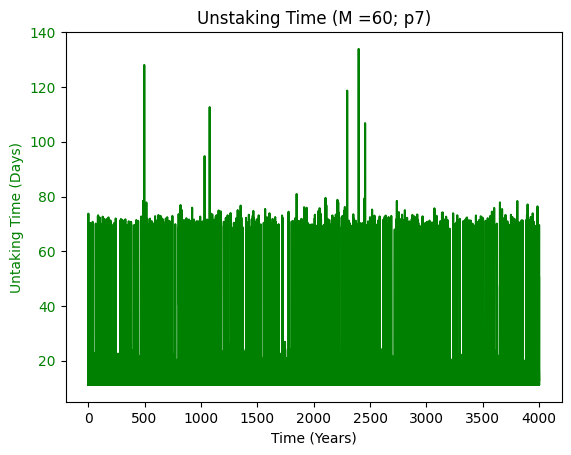

Queue Mean Time :12.376590128334323
Queue Stdev Time:5.5925596997117095


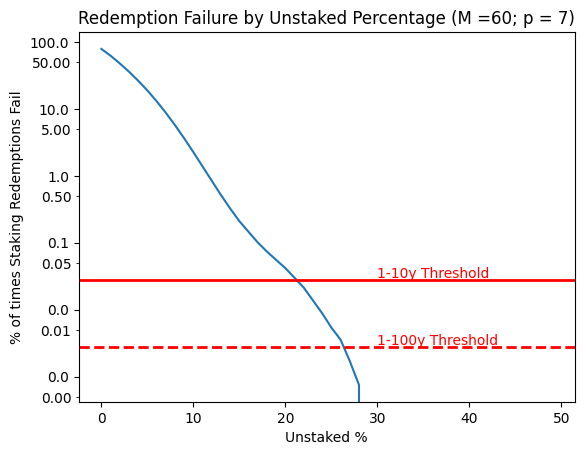

Tresh 10y:22
Tresh 100y:27


<Figure size 640x480 with 0 Axes>

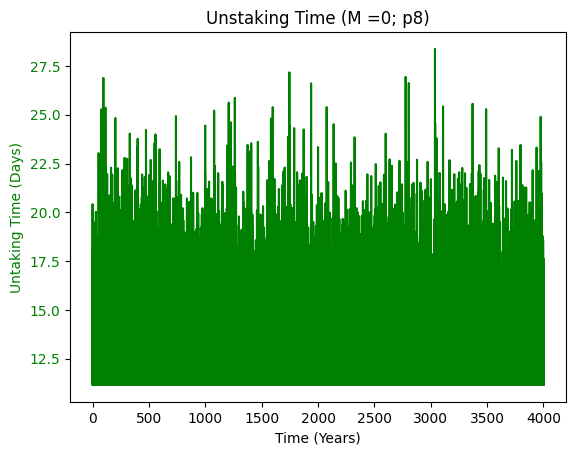

Queue Mean Time :11.640214968228364
Queue Stdev Time:1.0745675366542116


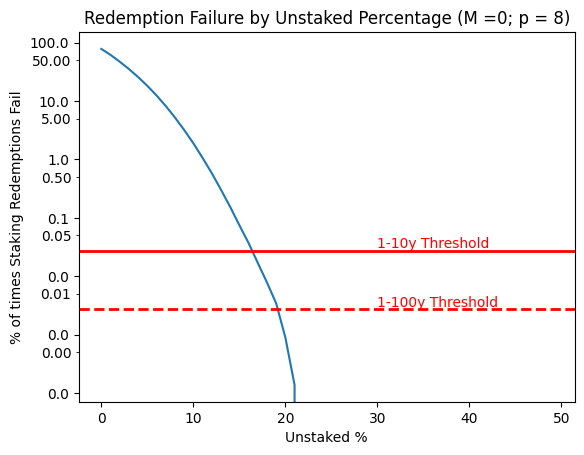

Tresh 10y:17
Tresh 100y:20


<Figure size 640x480 with 0 Axes>

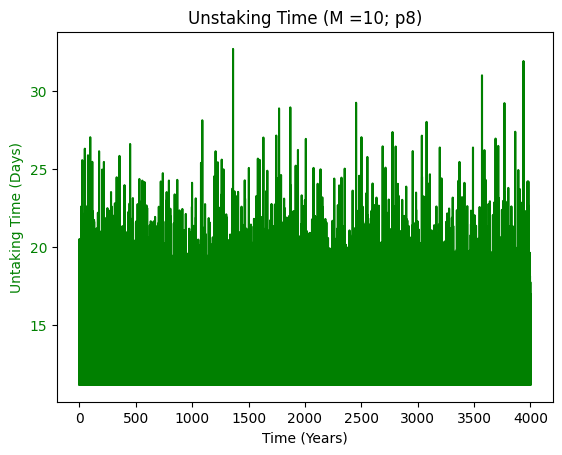

Queue Mean Time :11.661874272904821
Queue Stdev Time:1.1529880372821806


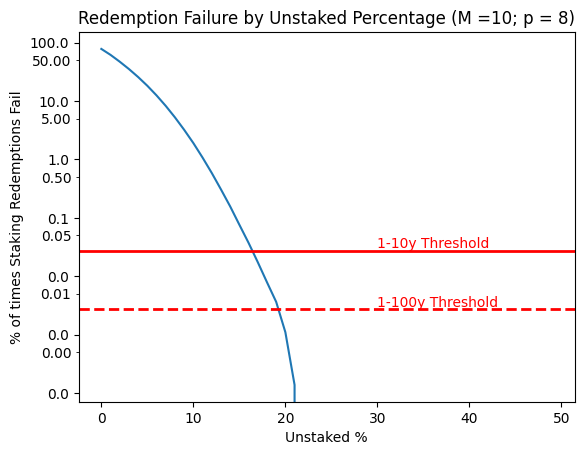

Tresh 10y:17
Tresh 100y:20


<Figure size 640x480 with 0 Axes>

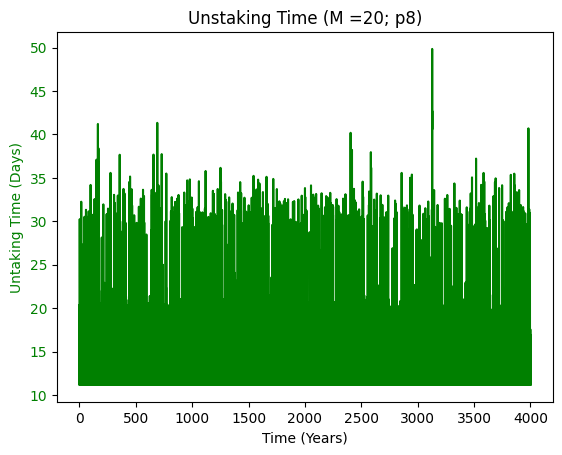

Queue Mean Time :11.718112623545625
Queue Stdev Time:1.5094291717889305


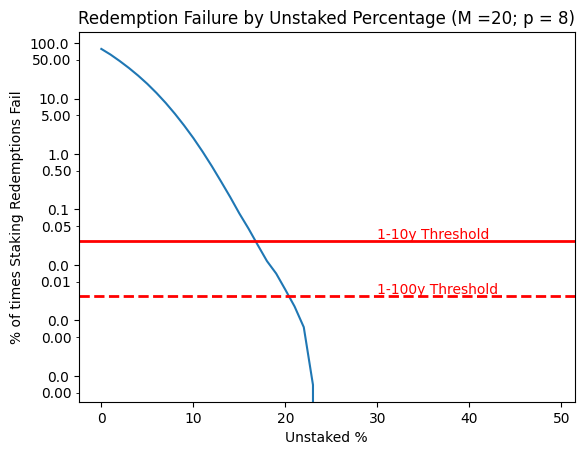

Tresh 10y:17
Tresh 100y:21


<Figure size 640x480 with 0 Axes>

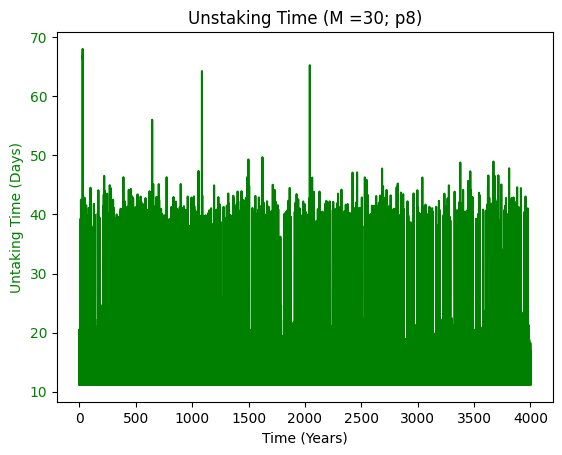

Queue Mean Time :11.824900466386604
Queue Stdev Time:2.256565534840167


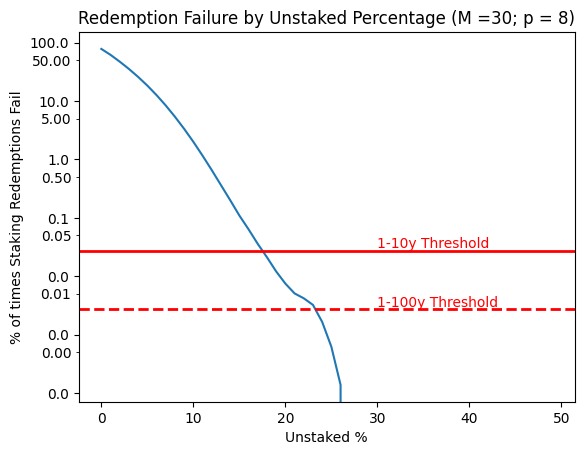

Tresh 10y:18
Tresh 100y:24


<Figure size 640x480 with 0 Axes>

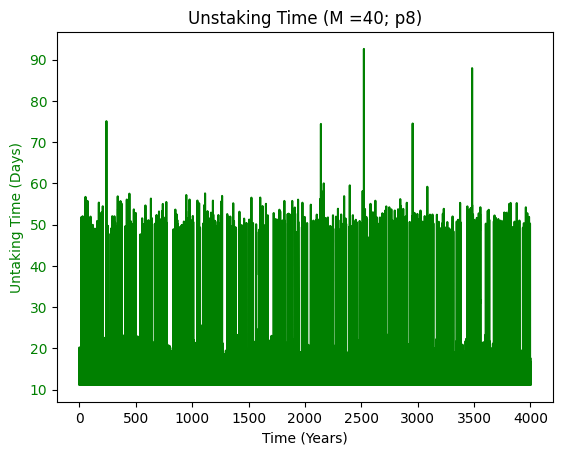

Queue Mean Time :11.941919198385488
Queue Stdev Time:3.1081134485121944


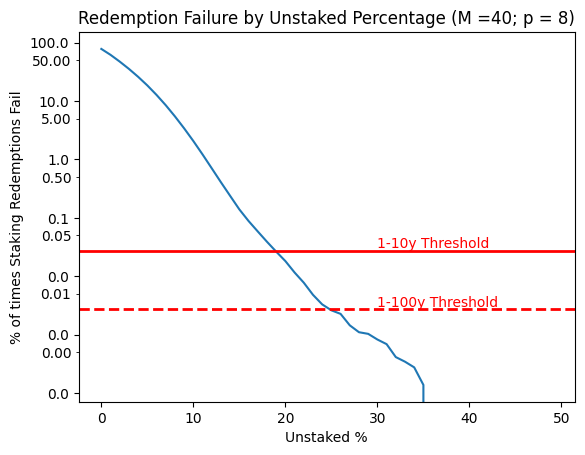

Tresh 10y:19
Tresh 100y:25


<Figure size 640x480 with 0 Axes>

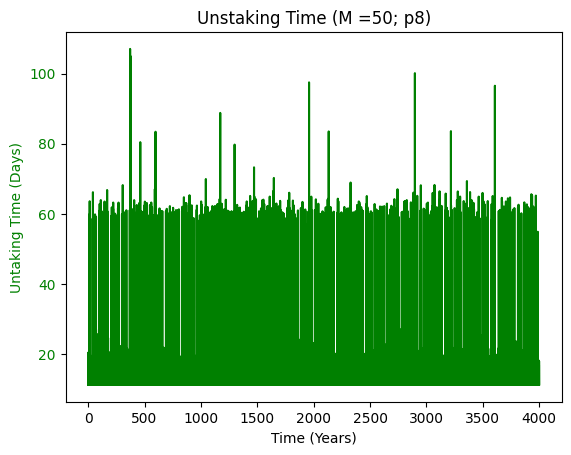

Queue Mean Time :12.15301031110861
Queue Stdev Time:4.372964087853676


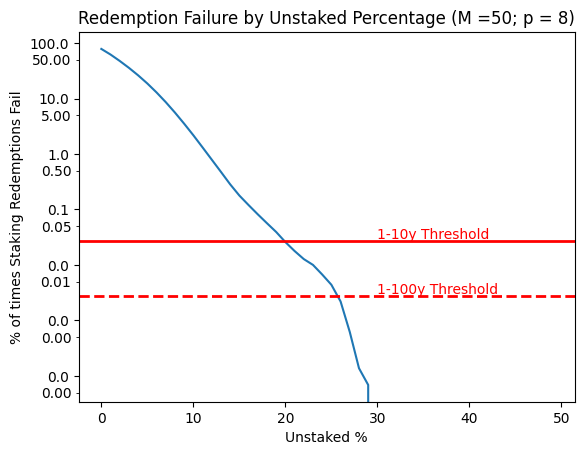

Tresh 10y:20
Tresh 100y:26


<Figure size 640x480 with 0 Axes>

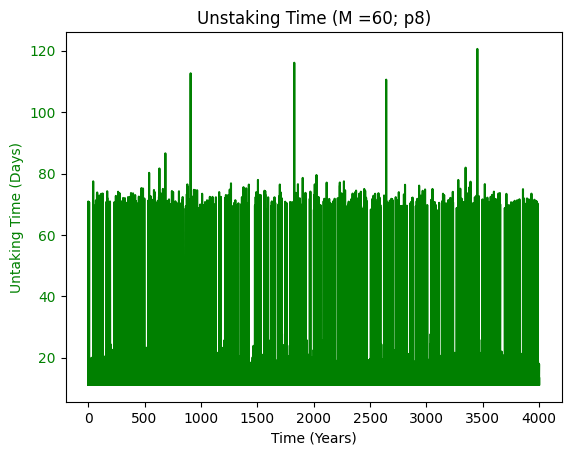

Queue Mean Time :12.3532861121422
Queue Stdev Time:5.500447084554143


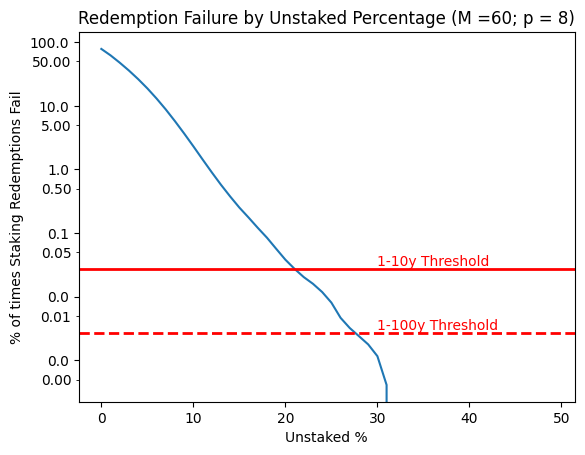

Tresh 10y:21
Tresh 100y:28


<Figure size 640x480 with 0 Axes>

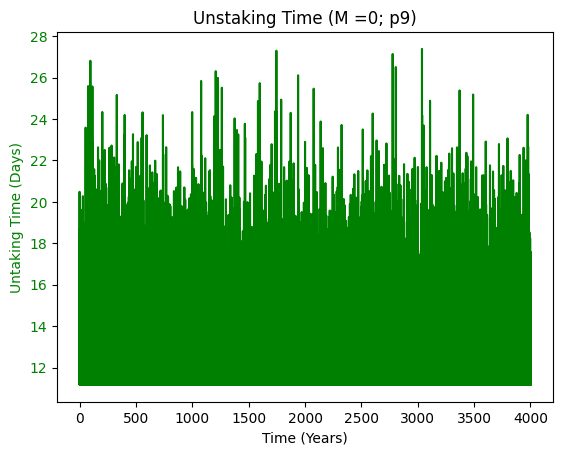

Queue Mean Time :11.640331178423239
Queue Stdev Time:1.0750173579851845


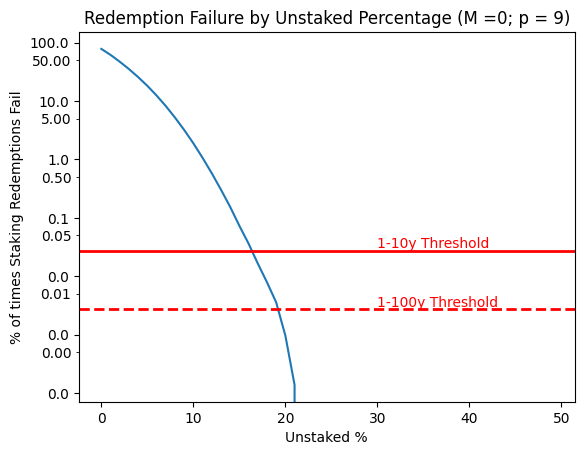

Tresh 10y:17
Tresh 100y:20


<Figure size 640x480 with 0 Axes>

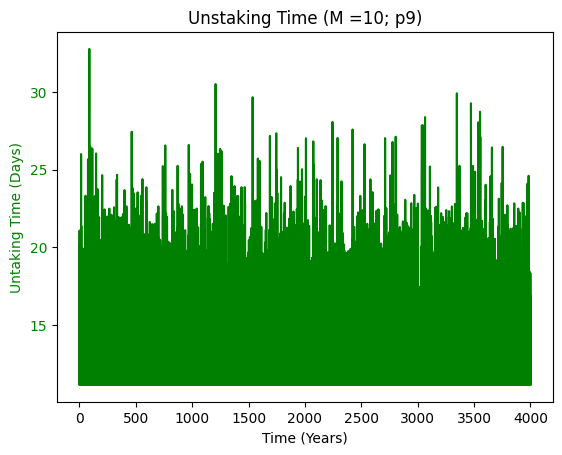

Queue Mean Time :11.659247043796888
Queue Stdev Time:1.14455905869002


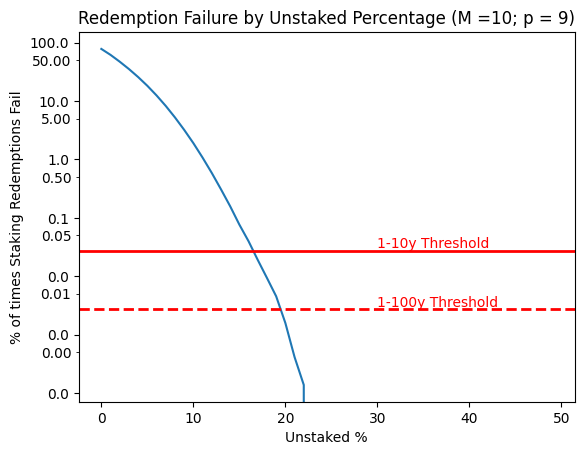

Tresh 10y:17
Tresh 100y:20


<Figure size 640x480 with 0 Axes>

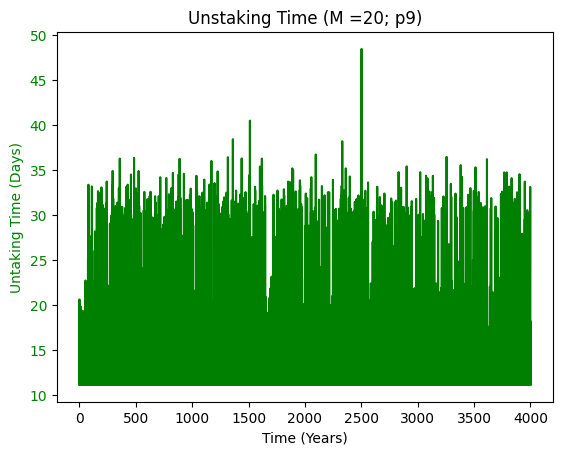

Queue Mean Time :11.715931629754712
Queue Stdev Time:1.4995261466796963


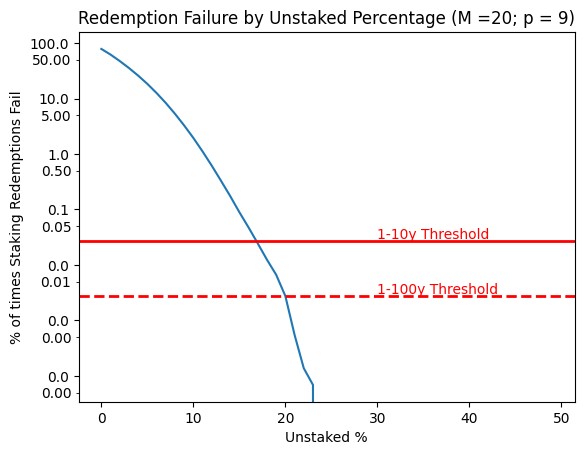

Tresh 10y:17
Tresh 100y:20


<Figure size 640x480 with 0 Axes>

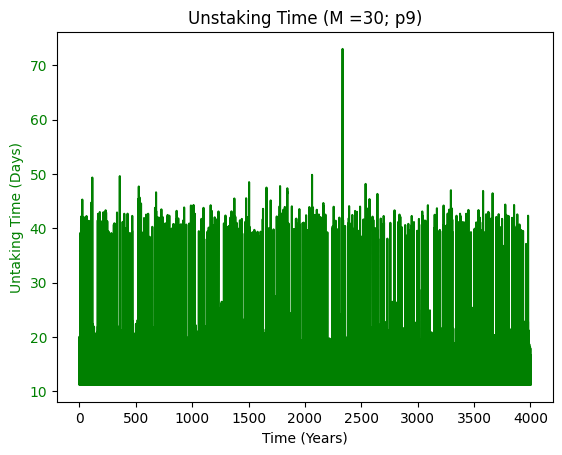

Queue Mean Time :11.783462140945847
Queue Stdev Time:2.0389127589501546


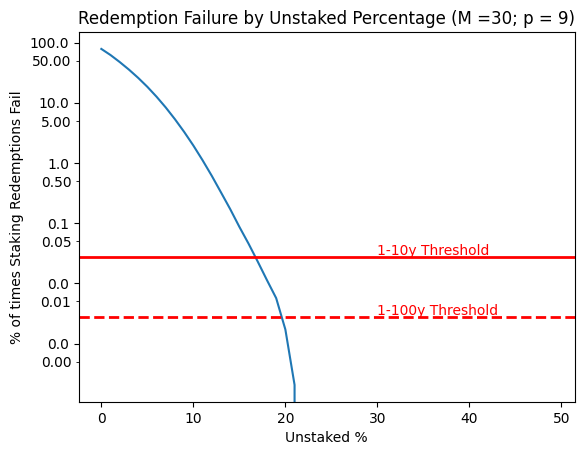

Tresh 10y:17
Tresh 100y:20


<Figure size 640x480 with 0 Axes>

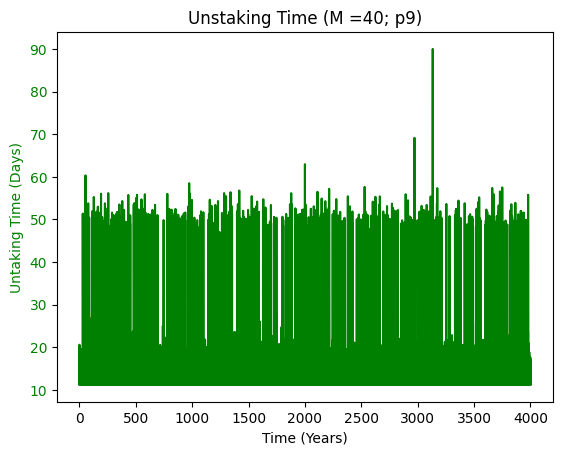

Queue Mean Time :11.911846702422011
Queue Stdev Time:2.930359585971938


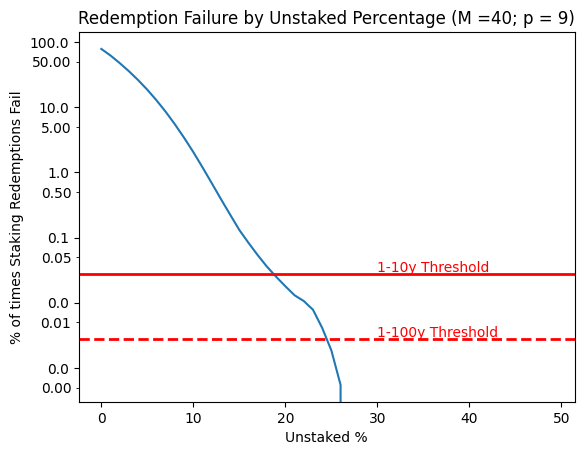

Tresh 10y:19
Tresh 100y:25


<Figure size 640x480 with 0 Axes>

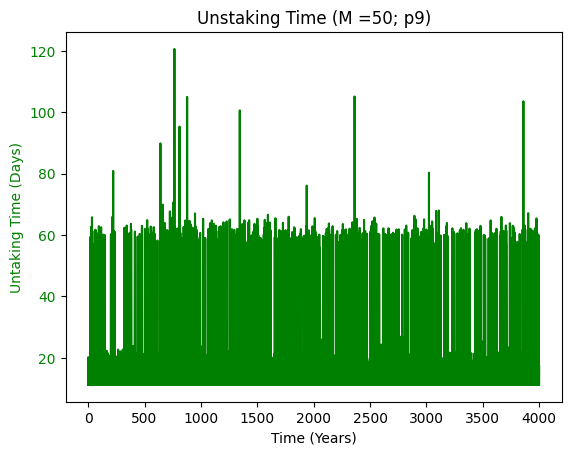

Queue Mean Time :12.068687756370442
Queue Stdev Time:4.0272233458748


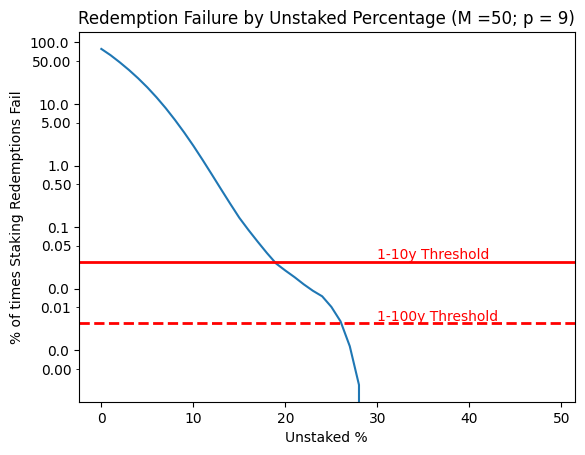

Tresh 10y:19
Tresh 100y:27


<Figure size 640x480 with 0 Axes>

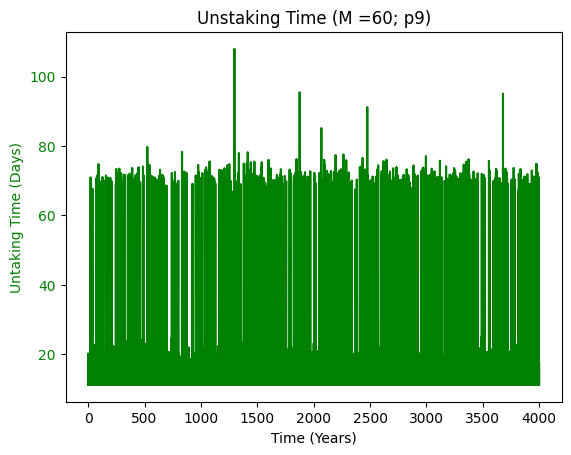

Queue Mean Time :12.279135208557467
Queue Stdev Time:5.2026697430269095


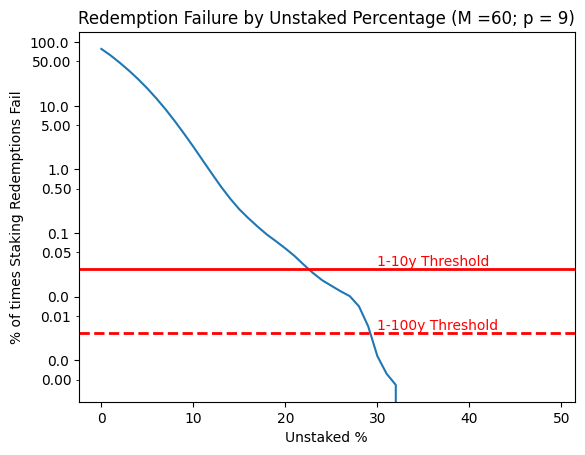

Tresh 10y:23
Tresh 100y:30


<Figure size 640x480 with 0 Axes>

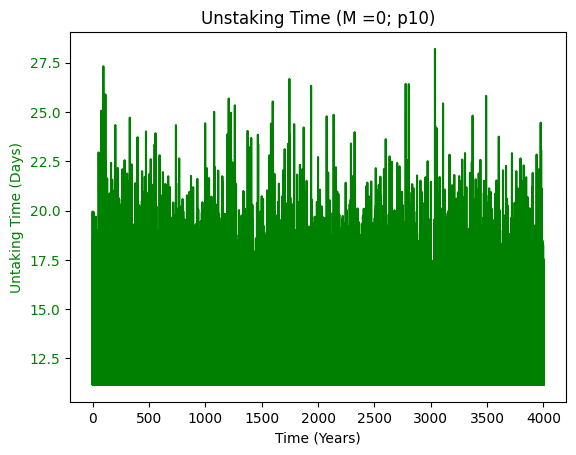

Queue Mean Time :11.640100945423667
Queue Stdev Time:1.0742899736108131


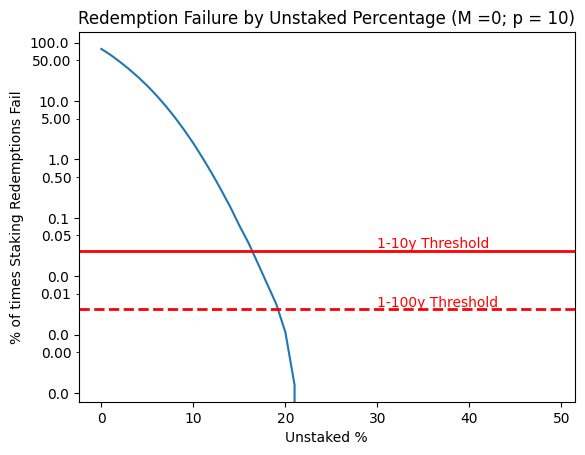

Tresh 10y:17
Tresh 100y:20


<Figure size 640x480 with 0 Axes>

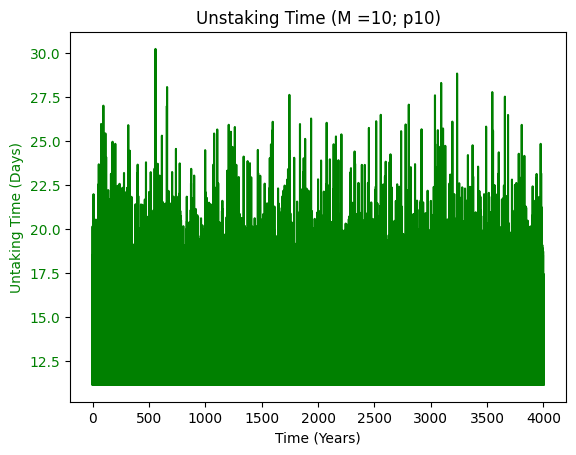

Queue Mean Time :11.657351182309675
Queue Stdev Time:1.134847653325001


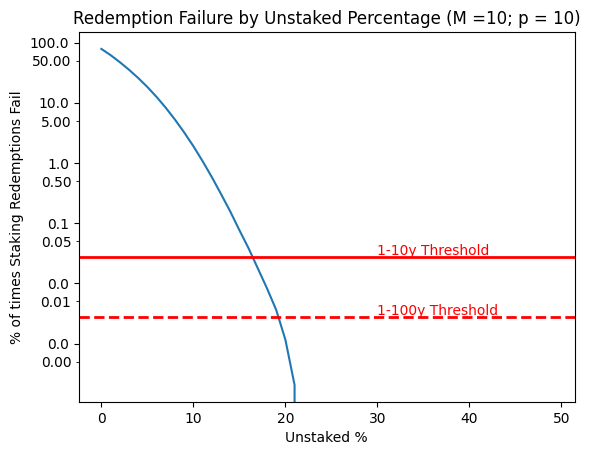

Tresh 10y:17
Tresh 100y:20


<Figure size 640x480 with 0 Axes>

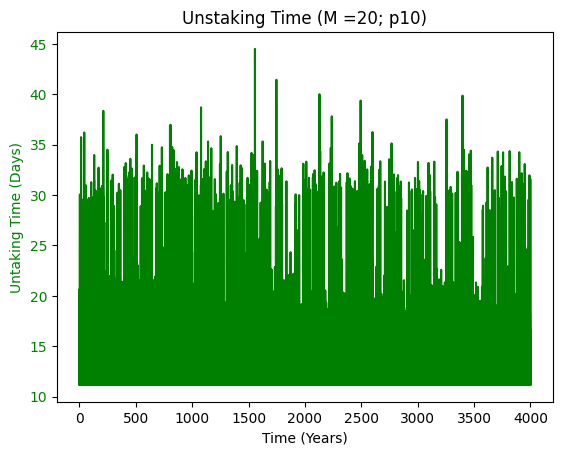

Queue Mean Time :11.703404144696387
Queue Stdev Time:1.4381165261613642


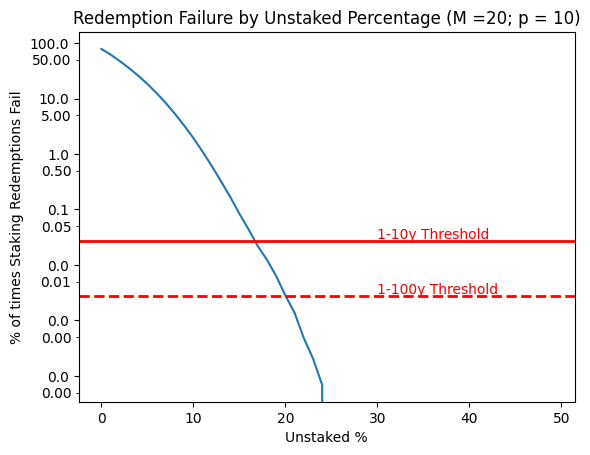

Tresh 10y:17
Tresh 100y:21


<Figure size 640x480 with 0 Axes>

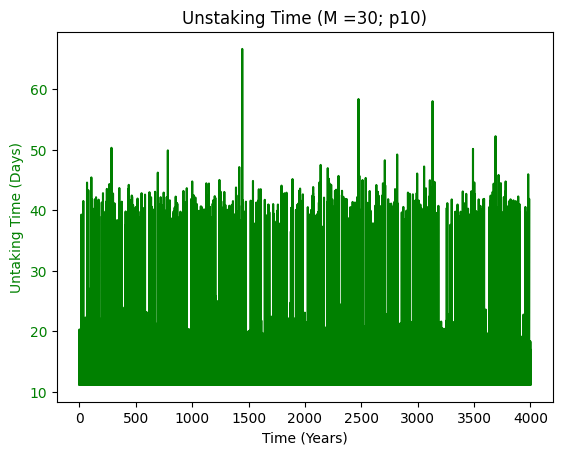

Queue Mean Time :11.792179625732112
Queue Stdev Time:2.0855777209531614


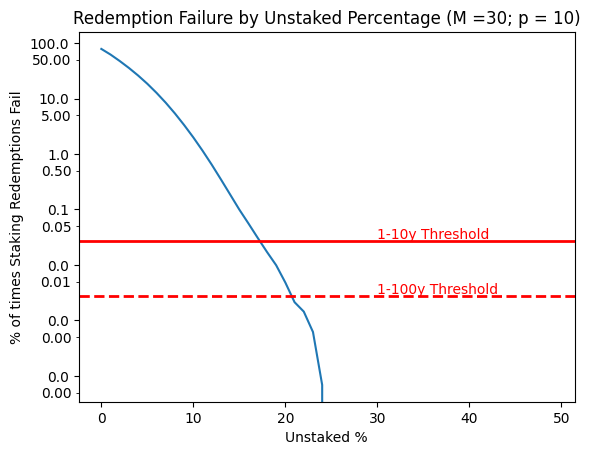

Tresh 10y:18
Tresh 100y:21


<Figure size 640x480 with 0 Axes>

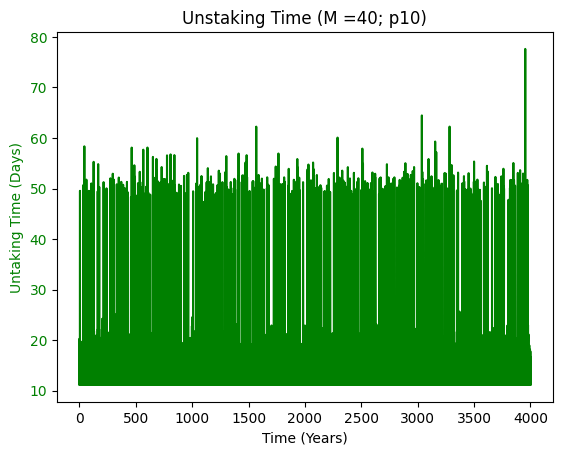

Queue Mean Time :11.905544800386142
Queue Stdev Time:2.903946624556506


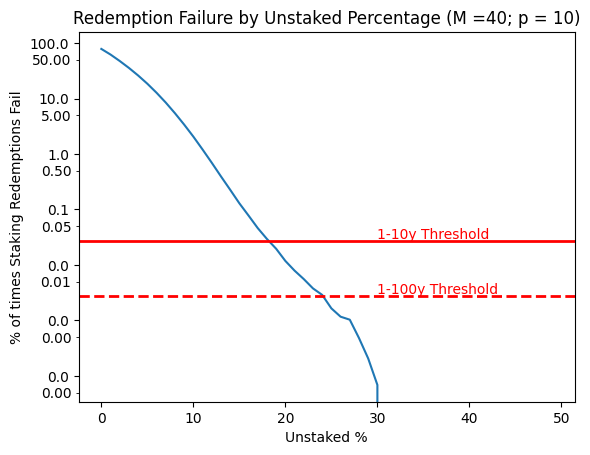

Tresh 10y:19
Tresh 100y:25


<Figure size 640x480 with 0 Axes>

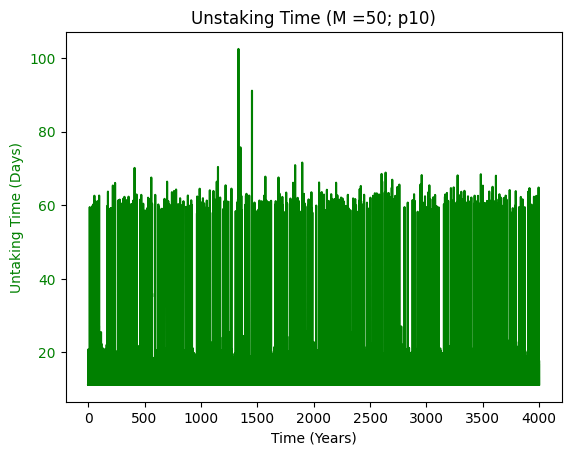

Queue Mean Time :12.04276011014186
Queue Stdev Time:3.87745238618128


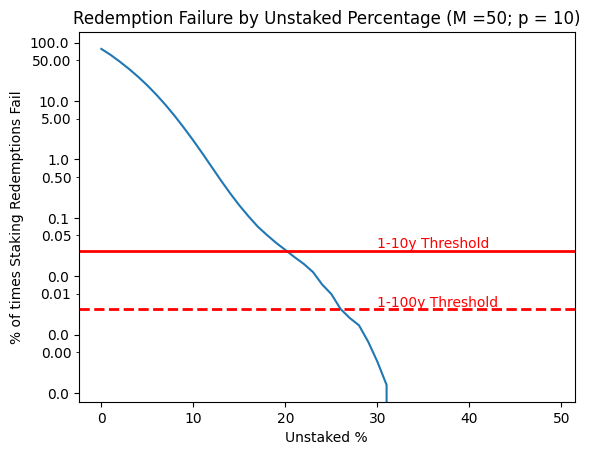

Tresh 10y:21
Tresh 100y:26


<Figure size 640x480 with 0 Axes>

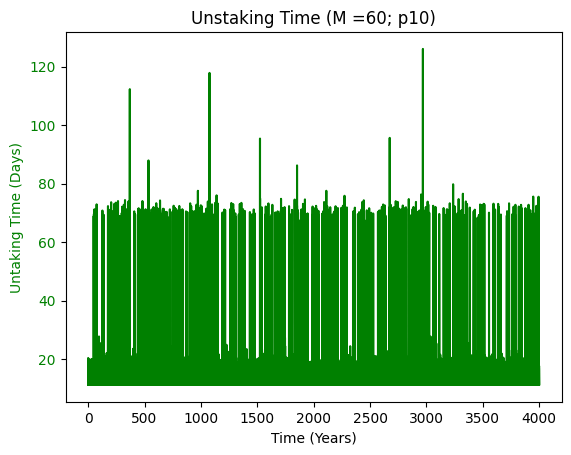

Queue Mean Time :12.185025595187637
Queue Stdev Time:4.8309891407957695


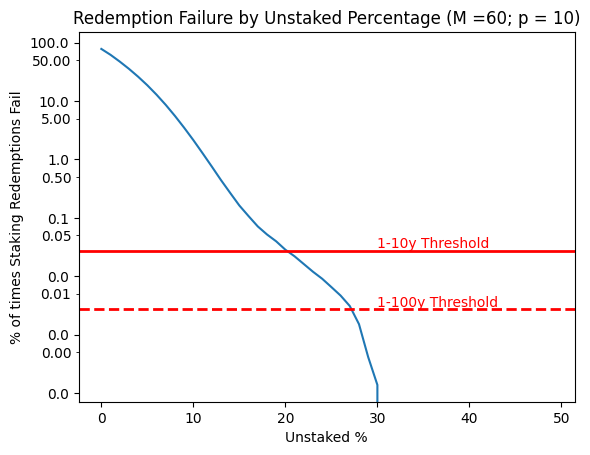

Tresh 10y:21
Tresh 100y:28
M     0   10  20  30  40  50  60
p                               
0.5   17  18  21  25  28  35  37
1.0   17  17  19  22  25  27  30
2.0   17  17  18  20  22  25  26
3.0   17  17  18  19  21  23  26
4.0   17  17  17  19  21  21  24
5.0   17  17  18  19  19  22  23
6.0   17  17  17  18  20  21  23
7.0   17  17  17  18  19  20  22
8.0   17  17  17  18  19  20  21
9.0   17  17  17  17  19  19  23
10.0  17  17  17  18  19  21  21
M     0   10  20  30  40  50  60
p                               
0.5   20  21  25  31  33  44  45
1.0   20  20  25  27  32  33  34
2.0   20  20  21  24  26  30  30
3.0   20  20  22  26  27  31  32
4.0   20  20  20  25  27  28  29
5.0   20  20  21  27  23  29  31
6.0   20  20  21  23  28  29  28
7.0   20  20  21  22  24  26  27
8.0   20  20  21  24  25  26  28
9.0   20  20  20  20  25  27  30
10.0  20  20  21  21  25  26  28


<Figure size 640x480 with 0 Axes>

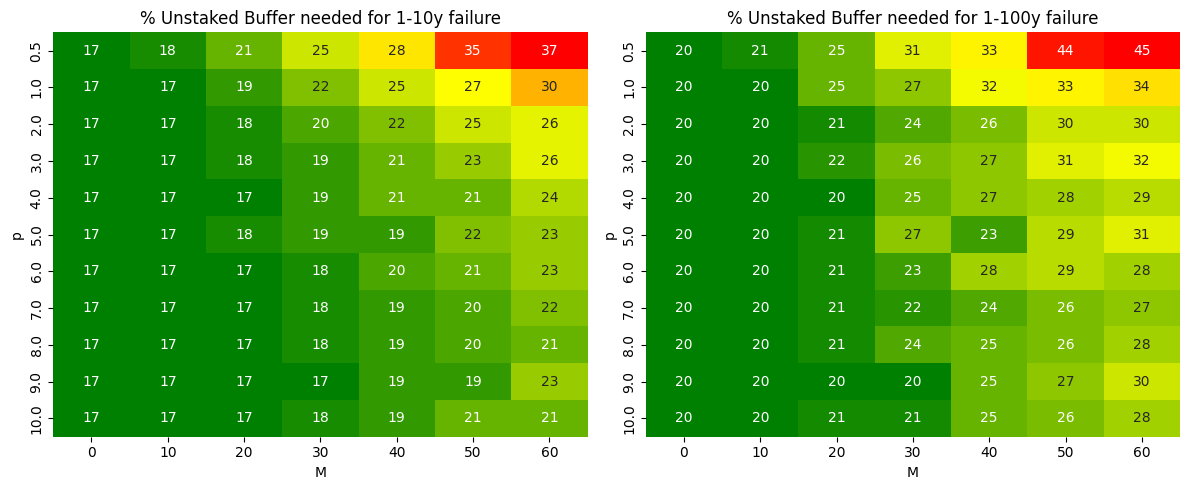

In [8]:
# Modeling random exit queue events


p = [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9 , 10]        # 1% chance of a spike
M = [0,10, 20, 30, 40, 50, 60] # Magnitude of the spike
mintresh10 = []
mintresh100 = []

for pi in p:
  for Mi in M:

    # baseline (tiny noise, mostly 0)
    baseline = np.random.normal(loc=0.1, scale=0.1, size=ndraws-1).clip(0)
    baseline[baseline<0] = 0

    # spike indicator
    spike_flag = np.random.binomial(1, 1/(pi*365), size=ndraws-1)

    # spike sizes (lognormal)

    # apply spikes only when indicator = 1
    spikes = spike_flag * Mi

    # total noise
    noise = baseline + spikes
    # The second step of the process is to simulate how long it takes to unstake ETH.
    # More info on staking timing can be found here
    #https://figment.io/insights/understanding-the-timeline-staking-and-unstaking-ethereum/

    # This is exit request time (5 epoch = 32 minutes), plus 256 epochs (27.3 hours),
    # plus exit time plus withdrawal sweeping.
    # I model exit queue time as normally distributed, with a high negative correlation with
    # ETP holding changes. Exit time is modeled so that a 100% ETP withdrawal would take 40days (9)with AUM of $10B) --> 100days with AUM of $25B.
    # Before pectra, sweep times are abotu 10 days. this is the max time to get swept.
    # This number would go down (maybe 30% or more) after pectra.
    # staking time is a brownian motion, with a minimum of maxdays + 32 min +27h.

    #maxdays is for the withdrawal sweep time.
    maxdays = 10

    #Need to model exit queue times.

    # exit_time is the exit time queue
    exit_time =  -113*np.array(holdings_amount_pct_change) + noise

    staking_time =[exit_time[0]]
    for i in range(1, len(exit_time)):
      # every day, I have yesterday's staking time less one day, plus more time because of the added exit time.
      staking_time.append(np.maximum(0,staking_time[i-1] + exit_time[i] -1))

    # add the fixed components of staking time
    staking_time = np.array(staking_time) + maxdays + 32/(60*24) + 27.3/24

    time_year = np.arange(1, ndraws)/365

    # Create a figure and axes
    fig, ax1 = plt.subplots()

    # Plot staking time on the primary y-axis (ax1)
    ax1.plot(time_year, staking_time, color='green', label='Staking Time (Days)')
    ax1.set_ylabel('Untaking Time (Days)', color='green')
    ax1.tick_params('y', labelcolor='green')

    # Set the title and x-axis label
    plt.title('Unstaking Time (M =' + str(Mi) + '; p' + str(pi) +')')
    plt.xlabel('Time (Years)')

    # Display the plot
    plt.show()
    print('Queue Mean Time :'+str(staking_time.mean()))

    print('Queue Stdev Time:'+str(staking_time.std()))

    filename = f"queue_time_p{pi}_M{Mi}.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    # The final step is to estimate how often ETH is not delivered because the ETF runs
    # out of unstaked ETH, and the queue prevents the ETF issuer to unstake ETH

    above_threshold_percentage = []

    #Loop for each threshold from 0% to 50%. For each threshold level, I loop through the draws (i)
    # to find the wait time (staking_time[i]) and see whether the maximum drawdown of holding during
    # that waiting period is greater than the threshold (i.e. delivery failure).
    # (small note: when I loop through the draws, I stop a bit earlier than the end of times,
    # because I need to look forward until the end of the waiting period)
    redemption = []
    for i in range(len(staking_time)-round(np.max(staking_time))):
        wait = int(np.ceil(staking_time[i]))
        redemption.append((holdings_amount[i] - np.min(holdings_amount[i:i+wait]))/holdings_amount[i])

    for threshold in range(0,50,1):
      above_threshold_percentage.append(sum(1 for x in redemption if x > threshold/100) / len(redemption) * 100)

    # Plot graph of delivery failure over threshold

    plt.plot(above_threshold_percentage)
    plt.xlabel('Unstaked %')
    plt.ylabel('% of times Staking Redemptions Fail')
    plt.title('Redemption Failure by Unstaked Percentage (M =' + str(Mi) + '; p = ' + str(pi)+')')
    plt.yscale('log')
    plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
    plt.ticklabel_format(axis='y', style='plain')
    plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10, subs=[1.0])) # Major ticks at powers of 10
    plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10, subs=np.arange(0, 10,5))) # Minor ticks at intermediate values
    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter("%3.1f"))  # Format minor tick labels
    plt.gca().yaxis.set_minor_formatter(ticker.FormatStrFormatter("%3.2f"))  # Format minor tick labels

    y10 = 0.0274
    y100 = 0.00274
    plt.axhline(y=y10, color='red', linestyle='-', linewidth=2, label='1-10y Threshold')
    plt.axhline(y=y100, color='red', linestyle='--', linewidth=2, label='1-100y Threshold')
    plt.text(x=30, y=y10 + y10/10 , s='1-10y Threshold', color='red', fontsize=10)
    plt.text(x=30, y=y100+ y100/10, s='1-100y Threshold', color='red', fontsize=10)
    plt.show()

    filename = f"threshold_p{pi}_M{Mi}.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")

    mintresh10.append({"p":pi, "M":Mi, "T": len([x for x in above_threshold_percentage if x > 0.0274]) })
    mintresh100.append({"p":pi, "M":Mi, "T": len([x for x in above_threshold_percentage if x > 0.00274]) })
    print('Tresh 10y:' + str(len([x for x in above_threshold_percentage if x > 0.0274])))
    print('Tresh 100y:' + str(len([x for x in above_threshold_percentage if x > 0.00274])))


cmap = LinearSegmentedColormap.from_list("green_red", ["green", "yellow", "red"])

df_thres10 = pd.DataFrame(mintresh10)
matrix10 = df_thres10.pivot(index="p", columns="M", values="T")
print(matrix10)

df_thres100 = pd.DataFrame(mintresh100)
matrix100 = df_thres100.pivot(index="p", columns="M", values="T")
print(matrix100)


# Plot heatmaps
plt.figure(figsize=(12, 5))

# Heatmap for threshold 10
plt.subplot(1, 2, 1)
sns.heatmap(matrix10, annot=True, fmt=".0f", cmap=cmap, cbar=False)
plt.title("% Unstaked Buffer needed for 1-10y failure")
plt.xlabel("M")
plt.ylabel("p")

# Heatmap for threshold 100
plt.subplot(1, 2, 2)
sns.heatmap(matrix100, annot=True, fmt=".0f", cmap=cmap, cbar=False)
plt.title("% Unstaked Buffer needed for 1-100y failure")
plt.xlabel("M")
plt.ylabel("p")

plt.tight_layout()
plt.show()